# 📊 BACKTEST HISTÓRICO CON VENTANAS DESLIZANTES

Este notebook implementa un backtest histórico completo usando ventanas deslizantes de 5 años, comparando dos enfoques de gestión de cartera bajo apalancamiento controlado. Está pensado para evaluar robustez, sensibilidad a condiciones de mercado y disciplina de aportaciones periódicas (DCA) en diferentes períodos calendario.

## Objetivos
- Evaluar el desempeño relativo de dos estilos de gestión con el mismo universo de activos y las mismas aportaciones mensuales.
- Medir métricas avanzadas (rentabilidad, riesgo, drawdown, ratios de calidad) sobre múltiples ventanas históricas no solapadas.
- Visualizar trayectorias y zonas de margen crítico para entender el riesgo de margin call.

## Comparación: Gestión ACTIVA vs PASIVA
- **CON DCA (Activo)**: Rebalanceo hacia pesos objetivo y despliegue condicional de las aportaciones según señales (desviación de pesos, volatilidad, drawdown y colchón de margen).
- **SIN DCA (Pasivo)**: Sin rebalanceo y sólo se realizan aportaciones cuando la palanca efectiva supera un umbral; se prioriza mantener el leverage mínimo sin recurrir a borrow adicional.

Ambas estrategias usan contribuciones mensuales de $2,000 y contemplan reborrow sujeto a reglas de margen para sostener el leverage objetivo cuando sea seguro.

## Metodología (resumen)
- Se descargan precios históricos y se calculan retornos logarítmicos diarios.
- Se extraen ventanas no solapadas para construir conjuntos de entrenamiento y prueba, evitando sesgos por sobre-muestreo.
- Se optimizan pesos en el conjunto de entrenamiento maximizando Sharpe apalancado sujeto a límites por activo.
- Se ejecutan backtests por cada ventana temporal, con y sin DCA, registrando equity, exposición y eventos de margen.

## Parámetros clave
- Capital inicial, contribución mensual, leverage objetivo y ratios de margen (seguro y crítico).
- Límites de peso por activo, umbrales de desviación/volatilidad para despliegue de DCA y factor de despliegue gradual.
- Periodo histórico usado para estimar estadísticas y fracción de datos para entrenamiento.

## Métricas y salidas
- Tablas comparativas (P50) de métricas: retorno total, CAGR, volatilidad anual, Sharpe/Sortino/Calmar, drawdowns y tiempo bajo agua.
- Tablas mensuales de rebalanceo mostrando el destino de cada aporte ($2,000) y el incremento de borrow.
- Gráficas de todas las trayectorias, percentiles y zonas de margen crítico; además, una simulación individual configurable.

## Reproducibilidad
- Se fija semilla aleatoria en la construcción de ventanas.
- El flujo separa claramente: descarga/limpieza de datos → optimización en train → evaluación por ventanas.

Sigue las celdas en orden para reproducir resultados y, si lo deseas, ajusta los metaparámetros para realizar análisis de sensibilidad y escenarios alternativos.

# 📦 Configuración del entorno

In [212]:
# ==============================================================================
# CONFIGURATION: Same parameters as Monte Carlo simulation
# ==============================================================================

METAPARAMETERS = {
    "initial_capital": 10_000,  # Starting Equity/Collateral in USD
    "monthly_contribution": 1_000,  # New Equity injected every month
    "leverage": 3,  # Leverage ratio
    "max_weight": 0.35,  # Constraint: Maximum weight per asset
    "min_weight": 0.15,  # Constraint: Minimum weight per asset
    "maintenance_margin_ratio": 0.05,  # Margin call triggers at 5% of exposure
    "drawdown_redeploy_threshold": 0.12,  # Drawdown level (12%) for full DCA
    "weight_deviation_threshold": 0.05,  # Max tolerated deviation from target weights
    "volatility_lookback_days": 63,  # Lookback window for volatility
    "volatility_redeploy_threshold": 0.18,  # Annualized volatility threshold
    "safe_margin_ratio": 0.20,  # Safe margin level (20%)
    "critical_margin_ratio": 0.10,  # Critical margin level (10%)
    "gradual_deploy_factor": 0.5,  # Fraction of DCA to deploy gradually
    "mean_return_shrinkage": 0.6,  # Shrinkage applied to historical mean returns for realism
    "train_test_split": 0.7,  # Fraction of TREND WINDOWS used for optimization
    "data_period": 6,  # Historical period (years) for optimization
    "max_leverage": 3.5,  # Maximum leverage at which passive contributions are deployed (SIN DCA)
    "min_leverage": 2.5,  # Minimum leverage to maintain with borrow in active strategy (CON DCA)
    "use_dynamic_sharpe_rebalance": False,
}

# Initial portfolio weights (will be optimized in Block 4)
PORTFOLIO_INITIAL = {
    "QQQ": 0,
    "SPY": 0.99,
    "EZU": 0,
    "GLD": 0.,
    "BTC-USD": 0.01,
}

# Portfolio weights (will be optimized and stored here)
PORTFOLIO_OPTIMIZED = PORTFOLIO_INITIAL.copy()

# Backtest configuration: Rolling 5-year windows
# From January 2015 to October 2020 (start months)
# Each window is 5 years long
ROLLING_START_YEAR = 2014
ROLLING_START_MONTH = 9  # January
ROLLING_END_YEAR = 2020
ROLLING_END_MONTH = 10  # October
WINDOW_YEARS = 5

yearly_trading_days = 252


# 📊 Descarga de datos históricos para optimización

Descargamos datos históricos completos que usaremos para optimizar la cartera antes de ejecutar los backtests.


In [213]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime
from scipy.optimize import minimize

# 📁 Snapshot Directory Setup
import os
import json

# Create snapshots directory if it doesn't exist
SNAPSHOTS_DIR = "snapshots"
if not os.path.exists(SNAPSHOTS_DIR):
    os.makedirs(SNAPSHOTS_DIR)

# Download historical data for optimization
def get_historical_data(tickers):
    """Downloads price data and calculates log returns robustly."""
    print("\n--- 📊 Descargando datos históricos para optimización ---")
    print("Descargando datos históricos...")
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=365 * METAPARAMETERS['data_period'] + METAPARAMETERS['data_period'])

    data = yf.download(list(tickers.keys()), start=start_date, end=end_date, progress=False)

    prices = pd.DataFrame()
    if 'Adj Close' in data.columns.get_level_values(0):
        prices = data['Adj Close'].copy()
    if 'Close' in data.columns.get_level_values(0):
        close_prices = data['Close']
        if prices.empty:
            prices = close_prices.copy()
        else:
            prices.fillna(close_prices, inplace=True)

    if prices.empty:
        raise ValueError("ERROR FATAL: Todos los datos de activos fallaron en descargarse. Verifica tickers o conexión.")

    prices = prices.dropna(axis=1, how='all')
    log_returns = np.log(prices / prices.shift(1)).dropna()
    print("Datos descargados y retornos calculados.")
    return log_returns


def extract_historical_trends(log_returns, min_window=5, max_window=90, step=5):
    """
    Extract NON-OVERLAPPING windows from historical data.
    
    Creates chunks where each day appears in EXACTLY ONE window.
    This eliminates all over-sampling bias while preserving temporal continuity.
    """
    all_windows = []

    num_days = len(log_returns)
    asset_names_list = log_returns.columns.tolist()

    # Create non-overlapping windows with random sizes
    current_idx = 0
    np.random.seed(42)  # For reproducibility

    while current_idx < num_days:
        # Random window size between min and max
        remaining_days = num_days - current_idx
        max_possible = min(max_window, remaining_days)

        if max_possible < min_window:
            # If less than min_window days remain, add them to previous window or skip
            if all_windows:
                # Extend last window
                last_window = all_windows[-1]
                extended_returns = log_returns.iloc[last_window['start_idx']:num_days].values
                last_window['returns'] = extended_returns
                last_window['length'] = len(extended_returns)
            break

        # Random size for this window
        window_size = np.random.randint(min_window, max_possible + 1)
        end_idx = current_idx + window_size

        # Get returns for this window
        window_returns = log_returns.iloc[current_idx:end_idx].values

        all_windows.append({
            'start_idx': current_idx,
            'length': window_size,
            'returns': window_returns.copy()
        })

        current_idx = end_idx

    return all_windows, asset_names_list

TRAIN_SPLIT = METAPARAMETERS["train_test_split"]
MEAN_RETURN_SHRINKAGE = METAPARAMETERS["mean_return_shrinkage"]

# Execute data download
log_returns_full = get_historical_data(PORTFOLIO_INITIAL)

# STEP 1: Extract ALL windows from full historical data
print("--- Paso 1: Extrayendo ventanas de todo el histórico (sin clasificación) ---")
all_trends_list, asset_names_from_trends = extract_historical_trends(
    log_returns_full,
    min_window=5,
    max_window=90,
    step=5
)

num_total_trends = len(all_trends_list)
num_train_trends = int(num_total_trends * TRAIN_SPLIT)

print("\n--- Paso 2: División ALEATORIA de tendencias (no temporal) ---")
print(f"   Total ventanas de tendencias extraídas: {num_total_trends}")
print(f"   Ventanas para optimización (train): ~{num_train_trends} ({TRAIN_SPLIT * 100:.0f}%)")
print(f"   Ventanas para test: ~{num_total_trends - num_train_trends} ({100 - TRAIN_SPLIT * 100:.0f}%)")

# STEP 2: Random split of trends (not temporal)
np.random.seed(42)  # For reproducibility
indices = np.arange(num_total_trends)
np.random.shuffle(indices)

train_indices = set(indices[:num_train_trends])
test_indices = set(indices[num_train_trends:])

# Separate trends into train and test sets
train_trends_list = [all_trends_list[i] for i in train_indices]
test_trends_list = [all_trends_list[i] for i in test_indices]

print(f"   ✅ Train: {len(train_trends_list)} ventanas | Test: {len(test_trends_list)} ventanas")
print("   🔄 Las ventanas están mezcladas aleatoriamente de diferentes épocas temporales\n")

# STEP 3: Reconstruct train/test datasets from non-overlapping windows
# Train dataset (used for optimization statistics)
train_daily_returns_list = [trend['returns'] for trend in train_trends_list]

if train_daily_returns_list:
    train_daily_returns_array = np.vstack(train_daily_returns_list)
    train_daily_returns_df = pd.DataFrame(train_daily_returns_array, columns=log_returns_full.columns)

    cov_matrix = train_daily_returns_df.cov()
    historical_mean_returns = train_daily_returns_df.mean()
    mean_returns = (historical_mean_returns * MEAN_RETURN_SHRINKAGE).values

    print("--- Paso 3: Estadísticas para optimización ---")
    print(f"   Días reconstruidos de ventanas train (sin solapamiento): {len(train_daily_returns_df)}")
else:
    raise ValueError("No hay tendencias train disponibles para optimización")

try:
    L = np.linalg.cholesky(cov_matrix.values)
    print("Matriz de Covarianza (Cholesky) calculada exitosamente.")
except np.linalg.LinAlgError:
    print("\nERROR FATAL: La matriz de covarianza es singular. Usando matriz diagonal (sin correlación).")
    L = np.diag(np.sqrt(np.diag(cov_matrix.values)))

print(f"Días de Trading Anuales Estimados (FIJO): {yearly_trading_days}")
print("Factor de shrink aplicado a retornos medios para realismo.")



--- 📊 Descargando datos históricos para optimización ---
Descargando datos históricos...
Datos descargados y retornos calculados.
--- Paso 1: Extrayendo ventanas de todo el histórico (sin clasificación) ---

--- Paso 2: División ALEATORIA de tendencias (no temporal) ---
   Total ventanas de tendencias extraídas: 26
   Ventanas para optimización (train): ~18 (70%)
   Ventanas para test: ~8 (30%)
   ✅ Train: 18 ventanas | Test: 8 ventanas
   🔄 Las ventanas están mezcladas aleatoriamente de diferentes épocas temporales

--- Paso 3: Estadísticas para optimización ---
   Días reconstruidos de ventanas train (sin solapamiento): 802
Matriz de Covarianza (Cholesky) calculada exitosamente.
Días de Trading Anuales Estimados (FIJO): 252
Factor de shrink aplicado a retornos medios para realismo.


/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_31853/2858403806.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.keys()), start=start_date, end=end_date, progress=False)


# 🧮 Funciones de optimización (Sharpe Ratio)

Definimos las funciones para calcular métricas del portfolio y maximizar el Sharpe Ratio apalancado.


In [214]:
# Block 3: Optimization Functions (Sharpe Ratio)

def calculate_portfolio_metrics(weights, log_returns, yearly_trading_days):
    """Calculates the Annualized Return and Volatility of the portfolio based on weights."""
    # Ensure weights sum to 1 to maintain correct scaling for mean and variance
    weights = weights / np.sum(weights)

    # Daily metrics from Block 2
    global mean_returns, cov_matrix

    # Daily mean return (dot product of means and weights)
    mean_daily_return = np.sum(mean_returns * weights)

    # Daily variance (Matrix multiplication: W' * Cov * W)
    portfolio_variance_daily = weights.T @ cov_matrix @ weights

    # Annualized Return (Geometric/Simplified)
    portfolio_return_annualized = mean_daily_return * yearly_trading_days

    # Annualized Volatility
    portfolio_volatility_annualized = np.sqrt(portfolio_variance_daily * yearly_trading_days)

    return portfolio_return_annualized, portfolio_volatility_annualized


def objective_function(weights, log_returns, yearly_trading_days, risk_free_rate=0.02):
    """Objective function to be minimized: Negative Sharpe Ratio."""
    weights /= np.sum(weights)  # Normalize weights for optimization step

    r_annual, vol_annual = calculate_portfolio_metrics(weights, log_returns, yearly_trading_days)

    # Apply leverage to annual metrics (The core assumption of this model)
    r_leveraged = r_annual * METAPARAMETERS["leverage"]
    vol_leveraged = vol_annual * METAPARAMETERS["leverage"]

    # Sharpe Ratio: (Return - Risk-Free Rate) / Volatility
    sharpe_ratio = (r_leveraged - risk_free_rate) / vol_leveraged

    # Minimize the negative Sharpe Ratio to maximize the positive Sharpe Ratio
    return -sharpe_ratio


# 🎯 Ejecución de la optimización de cartera

Ejecutamos la optimización para encontrar los pesos óptimos que maximizan el Sharpe Ratio apalancado.


In [215]:
# Block 4: Execute Portfolio Optimization

print("\n--- 🎯 Bloque 4: Optimización de Cartera ---")

# 1. Define constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

max_w = METAPARAMETERS["max_weight"]
min_w = METAPARAMETERS.get("min_weight", 0.0)
asset_names = list(PORTFOLIO_INITIAL.keys())

if min_w > max_w:
    raise ValueError("min_weight cannot be greater than max_weight")
bounds = tuple((min_w, max_w) for _ in asset_names)

# 2. Initial guess (current/initial portfolio weights)
weights_array_initial = np.array(list(PORTFOLIO_INITIAL.values()))
initial_weights = weights_array_initial / np.sum(weights_array_initial)

# 3. Execute the optimization using SLSQP
# CRITICAL: Use TRAIN trends data only for optimization (avoid look-ahead bias)
optimized_results = minimize(
    objective_function,
    initial_weights,
    args=(train_daily_returns_df, yearly_trading_days),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# 4. Extract and present the optimal weights
optimal_weights = optimized_results['x']
optimal_weights = optimal_weights / np.sum(optimal_weights)  # Re-normalize
optimal_weights = np.round(optimal_weights, 4)

optimal_portfolio = pd.Series(optimal_weights, index=asset_names)

# Use TRAIN trends data for performance metrics (portfolio optimized on train data)
r_opt, vol_opt = calculate_portfolio_metrics(optimal_weights, train_daily_returns_df, yearly_trading_days)

print("Optimización exitosa.")
print(f"\nPesos Óptimos (Máximo Sharpe Ratio, Máximo {METAPARAMETERS['max_weight']} por Activo):")
print(optimal_portfolio.to_markdown())

print("\n--- Performance de Cartera Óptima (Sin Apalancamiento) ---")
print(f"Retorno Anualizado: {r_opt * 100:.2f}%")
print(f"Volatilidad Anualizada: {vol_opt * 100:.2f}%")
print(f"Sharpe Ratio: {-optimized_results['fun']:.2f} (Apalancado)")

# 5. Update PORTFOLIO_OPTIMIZED with optimized weights
PORTFOLIO_OPTIMIZED = optimal_portfolio.to_dict()
weights_array_optimized = optimal_weights


--- 🎯 Bloque 4: Optimización de Cartera ---
Optimización exitosa.

Pesos Óptimos (Máximo Sharpe Ratio, Máximo 0.35 por Activo):
|         |    0 |
|:--------|-----:|
| QQQ     | 0.2  |
| SPY     | 0.15 |
| EZU     | 0.35 |
| GLD     | 0.15 |
| BTC-USD | 0.15 |

--- Performance de Cartera Óptima (Sin Apalancamiento) ---
Retorno Anualizado: 12.36%
Volatilidad Anualizada: 20.67%
Sharpe Ratio: 0.57 (Apalancado)


# 📥 Función de descarga de datos para backtest

Esta función descarga datos históricos para cada ventana de backtest específica.

In [216]:
def download_backtest_data(tickers, start_date, end_date, verbose=True):
    """
    Download historical price data for the backtest period.

    Args:
        tickers: Dictionary of ticker symbols
        start_date: Start date for backtest
        end_date: End date for backtest
        verbose: If True, print progress messages

    Returns:
        log_returns: DataFrame with daily log returns
        prices: DataFrame with adjusted close prices
    """
    if verbose:
        print(f"\n📥 Descargando datos: {start_date} a {end_date}")

    # Convert to datetime for yfinance
    start_datetime = datetime.datetime.combine(start_date, datetime.time())
    end_datetime = datetime.datetime.combine(end_date, datetime.time())

    data = yf.download(
        list(tickers.keys()),
        start=start_datetime,
        end=end_datetime,
        progress=False,  # Disable progress bar for multiple downloads
    )

    # Extract prices
    prices = pd.DataFrame()
    if "Adj Close" in data.columns.get_level_values(0):
        prices = data["Adj Close"].copy()
    if "Close" in data.columns.get_level_values(0):
        close_prices = data["Close"]
        if prices.empty:
            prices = close_prices.copy()
        else:
            prices.fillna(close_prices, inplace=True)

    if prices.empty:
        raise ValueError(
            f"ERROR: No se pudieron descargar los datos para {start_date} a {end_date}"
        )

    # Ensure all tickers are present
    missing_tickers = set(tickers.keys()) - set(prices.columns)
    if missing_tickers:
        if verbose:
            print(f"⚠️  Advertencia: Faltan tickers: {missing_tickers}")

    # Calculate log returns
    log_returns = np.log(prices / prices.shift(1)).dropna()

    if verbose:
        print(f"   ✅ {len(log_returns)} días de trading")

    return log_returns, prices

# 📅 Generación de ventanas deslizantes

In [217]:
def generate_rolling_windows(
    start_year, start_month, end_year, end_month, window_years
):
    """
    Generate list of rolling window date ranges.

    Args:
        start_year: Starting year for first window
        start_month: Starting month for first window
        end_year: Ending year for last window start
        end_month: Ending month for last window start
        window_years: Length of each window in years

    Returns:
        List of tuples: [(start_date, end_date), ...]
    """
    windows = []
    current_year = start_year
    current_month = start_month

    while (current_year < end_year) or (
        current_year == end_year and current_month <= end_month
    ):
        window_start = datetime.date(current_year, current_month, 1)

        # Calculate end date (5 years later, same month)
        end_year_window = current_year + window_years
        window_end = datetime.date(end_year_window, current_month, 1)

        windows.append((window_start, window_end))

        # Move to next month
        if current_month == 12:
            current_month = 1
            current_year += 1
        else:
            current_month += 1

    return windows

# 💰 Inicialización de cartera

In [218]:
def initialize_portfolio(verbose=True):
    """
    Initialize portfolio state with starting capital and positions.

    Args:
        verbose: If True, print initialization details

    Returns:
        dict: Initial portfolio state
    """
    initial_capital = METAPARAMETERS["initial_capital"]
    leverage = METAPARAMETERS["leverage"]
    weights_array = np.array(list(PORTFOLIO_OPTIMIZED.values()))
    asset_names = list(PORTFOLIO_OPTIMIZED.keys())

    # Initial trading power
    initial_tp = initial_capital * leverage
    initial_position_values = initial_tp * weights_array

    portfolio_state = {
        "capital": initial_capital,
        "position_values": initial_position_values.copy(),
        "peak_capital": initial_capital,
        "equity_history": [],  # For volatility calculation
        "cash_flow_history": [-initial_capital],
        "monthly_distributions": [],  # Track monthly DCA deployments
        "daily_equity": [initial_capital],  # Track equity over time
        "daily_exposure": [np.sum(initial_position_values)],  # Track exposure over time
        "days_since_month_start": 0,
    }

    if verbose:
        print("\n💰 Inicializando cartera")
        print(f"Capital inicial: ${initial_capital:,.0f}")
        print(f"Leverage objetivo: {leverage}x")
        print(f"Trading Power inicial: ${initial_tp:,.0f}")

    return portfolio_state, asset_names, weights_array

# 📉 Aplicación de retornos diarios

In [219]:
def apply_daily_returns(
    portfolio_state, daily_returns_array, asset_names, weights_array
):
    """
    Apply daily returns to portfolio positions and update capital.

    Args:
        portfolio_state: Current portfolio state
        daily_returns_array: Array of log returns for each asset
        asset_names: List of asset names
        weights_array: Target portfolio weights

    Returns:
        bool: True if portfolio is still active, False if margin call occurred
    """
    position_values = portfolio_state["position_values"]
    capital = portfolio_state["capital"]

    # Calculate PnL for each asset
    pnl_by_asset = position_values * (np.exp(daily_returns_array) - 1)
    daily_pnl = np.sum(pnl_by_asset)

    # Update position values and capital
    position_values += pnl_by_asset
    capital += daily_pnl

    # Check for margin call
    exposure = np.sum(position_values)
    margin_ratio = capital / exposure if exposure > 0 else 1.0
    MAINTENANCE_RATIO = METAPARAMETERS["maintenance_margin_ratio"]

    margin_call = False
    if exposure > 0 and (capital <= 0 or margin_ratio <= MAINTENANCE_RATIO):
        margin_call = True
        capital = 0
        position_values.fill(0)

    # Update portfolio state
    portfolio_state["capital"] = capital
    portfolio_state["position_values"] = position_values
    portfolio_state["peak_capital"] = max(portfolio_state["peak_capital"], capital)

    return not margin_call

# 🔄 Rebalanceo mensual y DCA

In [220]:
def compute_optimal_sharpe_weights(log_returns_history, asset_names, yearly_trading_days):
    """
    Computes optimal portfolio weights maximizing the leveraged Sharpe ratio using accumulated historical log returns.

    Args:
        log_returns_history (pd.DataFrame): DataFrame of historical log returns up to rebalance point.
        asset_names (list): List of asset names (column order).
        yearly_trading_days (int): Number of trading days in a year.

    Returns:
        numpy.ndarray: Optimal weights per asset (aligned to asset_names order).
    """
    available_assets = [a for a in asset_names if a in log_returns_history.columns]
    mean_returns = log_returns_history[available_assets].mean().values
    cov_matrix = log_returns_history[available_assets].cov().values

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    max_w = METAPARAMETERS["max_weight"]
    min_w = METAPARAMETERS.get("min_weight", 0.0)
    bounds = tuple((min_w, max_w) for _ in available_assets)
    initial_weights = np.array([1.0 / len(available_assets)] * len(available_assets))

    def _portfolio_metrics(weights):
        weights = weights / np.sum(weights)
        mean_daily = np.sum(mean_returns * weights)
        port_var = weights.T @ cov_matrix @ weights
        ret_annual = mean_daily * yearly_trading_days
        vol_annual = np.sqrt(port_var * yearly_trading_days)
        return ret_annual, vol_annual

    def _neg_sharpe(weights, risk_free_rate=0.02):
        r_annual, vol_annual = _portfolio_metrics(weights)
        r_lever = r_annual * METAPARAMETERS["leverage"]
        vol_lever = vol_annual * METAPARAMETERS["leverage"]
        sharpe = (r_lever - risk_free_rate) / vol_lever if vol_lever > 0 else 0
        return -sharpe

    result = minimize(_neg_sharpe, initial_weights, method="SLSQP", bounds=bounds, constraints=constraints)
    optimal = result.x / np.sum(result.x) if np.sum(result.x) > 0 else initial_weights
    weights_final = np.zeros(len(asset_names))
    for i, a in enumerate(asset_names):
        if a in available_assets:
            weights_final[i] = optimal[available_assets.index(a)]
    return weights_final


def apply_monthly_rebalancing(
    portfolio_state, asset_names, weights_array, day_idx, log_returns, enable_dca=True
):
    """
    Apply monthly DCA contribution and dynamic Sharpe-optimal rebalancing from year 2 onwards.
    Handles correct monthly contribution, rebalances with optimal weights, and assigns borrow as needed.

    Args:
        portfolio_state: Current portfolio state.
        asset_names: List of asset names.
        weights_array: Target portfolio weights (used for year 1 only).
        day_idx: Current day index.
        log_returns: DataFrame with historical log returns.
        enable_dca: If True, use DCA strategy; if False, passive logic.

    Returns:
        dict: Monthly distribution record.
    """
    yearly_trading_days = METAPARAMETERS.get("yearly_trading_days", 252)
    month_num = (day_idx // int(yearly_trading_days / 12)) + 1
    # Config switch to enable/disable dynamic Sharpe rebalancing
    use_dynamic_sharpe = METAPARAMETERS.get("use_dynamic_sharpe_rebalance", False)
    current_weights = np.copy(weights_array)
    if use_dynamic_sharpe and month_num >= 13:
        hist_returns = log_returns.iloc[:day_idx+1]
        current_weights = compute_optimal_sharpe_weights(hist_returns, asset_names, yearly_trading_days)

    LEVERAGE = METAPARAMETERS["leverage"]
    MONTHLY_CONTRIBUTION = METAPARAMETERS["monthly_contribution"]
    DRAWDOWN_THRESHOLD = METAPARAMETERS["drawdown_redeploy_threshold"]
    WEIGHT_DEVIATION_THRESHOLD = METAPARAMETERS["weight_deviation_threshold"]
    VOLATILITY_THRESHOLD = METAPARAMETERS["volatility_redeploy_threshold"]
    GRADUAL_DEPLOY_FACTOR = METAPARAMETERS["gradual_deploy_factor"]
    VOLATILITY_LOOKBACK_DAYS = METAPARAMETERS["volatility_lookback_days"]
    MIN_LEVERAGE = METAPARAMETERS.get("min_leverage", LEVERAGE)

    capital = portfolio_state["capital"]
    position_values = portfolio_state["position_values"]
    peak_capital = portfolio_state["peak_capital"]
    exposure = np.sum(position_values)
    current_margin_ratio = capital / exposure if exposure > 0 else 1.0
    drawdown = 0.0
    if peak_capital > 0:
        drawdown = (capital / peak_capital) - 1.0
    weight_deviation = 0.0
    current_tp = exposure
    if current_tp > 0:
        curr_act_weights = position_values / current_tp
        weight_deviation = np.max(np.abs(curr_act_weights - current_weights))
    realized_vol = np.nan
    equity_history = portfolio_state["daily_equity"]
    if len(equity_history) >= 2:
        lookback_end = len(equity_history)
        lookback_start = max(0, lookback_end - VOLATILITY_LOOKBACK_DAYS - 1)
        window_equity = np.array(equity_history[lookback_start:lookback_end])
        if len(window_equity) > 1:
            returns_window = np.diff(np.log(window_equity))
            if len(returns_window) > 0:
                if len(returns_window) > 1:
                    daily_vol = np.std(returns_window, ddof=1)
                else:
                    daily_vol = np.std(returns_window)
                realized_vol = daily_vol * np.sqrt(yearly_trading_days)

    # === GESTIÓN PASIVA SIN DCA ===
    if not enable_dca:
        effective_leverage = current_tp / capital if capital > 0 else 0.0
        capital_distribution = {asset: 0.0 for asset in asset_names}
        equity_used_from_contribution = 0.0
        borrow_distribution = {asset: 0.0 for asset in asset_names}
        MAX_LEVERAGE = METAPARAMETERS.get("max_leverage", 4.0)
        if effective_leverage >= MAX_LEVERAGE and capital > 0:
            capital += MONTHLY_CONTRIBUTION
            portfolio_state["cash_flow_history"].append(-MONTHLY_CONTRIBUTION)
            curr_act_weights = position_values / current_tp if current_tp > 0 else current_weights
            equity_used_from_contribution = MONTHLY_CONTRIBUTION
            additional_exposure = equity_used_from_contribution
            additional_positions = additional_exposure * curr_act_weights
            position_values += additional_positions
            for idx, asset in enumerate(asset_names):
                capital_distribution[asset] = equity_used_from_contribution * curr_act_weights[idx]
        new_total_tp_used = np.sum(position_values)
        held_as_buffer = 0.0
        portfolio_state["capital"] = capital
        portfolio_state["position_values"] = position_values
        portfolio_state["peak_capital"] = max(peak_capital, capital)
        monthly_record = {
            "month": month_num,
            "capital": capital,
            "exposure": new_total_tp_used,
            "capital_added_to_positions": equity_used_from_contribution,
            "borrow_increase": 0.0,
            "borrow_tp_increase": 0.0,
            "margin_buffer": held_as_buffer,
            "distribution": capital_distribution.copy(),
            "borrow_distribution": borrow_distribution.copy(),
            "drawdown": drawdown,
            "weight_deviation": weight_deviation,
            "realized_volatility": realized_vol,
            "deploy_fraction": 0.0,
            "margin_ratio": current_margin_ratio,
        }
        portfolio_state["monthly_distributions"].append(monthly_record)
        return monthly_record

    # === DCA ===
    # 1) Siempre registrar el aporte mensual en DCA (capital y cash_flow)
    portfolio_state["cash_flow_history"].append(-MONTHLY_CONTRIBUTION)
    capital += MONTHLY_CONTRIBUTION

    # 2) Señal de despliegue
    deploy_fraction = 0.0
    if drawdown <= -DRAWDOWN_THRESHOLD:
        deploy_fraction = 1.0
    else:
        weight_condition = weight_deviation >= WEIGHT_DEVIATION_THRESHOLD
        vol_condition = (not np.isnan(realized_vol)) and (realized_vol <= VOLATILITY_THRESHOLD)
        if weight_condition or vol_condition:
            deploy_fraction = 1.0

    # 3) Objetivos de TP y mínimos de palanca
    desired_tp = capital * LEVERAGE
    effective_leverage = current_tp / capital if capital > 0 else 0.0

    # Siempre respetar MIN_LEVERAGE
    min_tp = capital * MIN_LEVERAGE
    target_tp = max(current_tp, min_tp)

    # Si hay señal, empujar hacia desired_tp con gradual deploy
    if deploy_fraction > 0:
        deploy_fraction = min(deploy_fraction, GRADUAL_DEPLOY_FACTOR)
        target_tp = max(target_tp, min(desired_tp, current_tp + MONTHLY_CONTRIBUTION * LEVERAGE * deploy_fraction))

    # 4) Rebalanceo hacia current_weights
    target_positions = target_tp * current_weights
    position_difference = target_positions - position_values
    buy_values = np.maximum(0, position_difference)
    sell_values = np.maximum(0, -position_difference)

    position_values += buy_values
    position_values -= sell_values

    # Normalizar a target_tp si hay desajuste numérico
    new_total_tp_used = np.sum(position_values)
    tolerance = 1e-6
    if target_tp > 0 and abs(new_total_tp_used - target_tp) > tolerance:
        position_values = position_values * (target_tp / new_total_tp_used)
        new_total_tp_used = target_tp

    # 5) Desglose de fuente: aporte vs borrow
    net_tp_change = new_total_tp_used - current_tp
    # TP que proviene del aporte (equity * leverage)
    tp_from_deposit = min(max(net_tp_change, 0.0), MONTHLY_CONTRIBUTION * LEVERAGE)
    equity_used_from_contribution = tp_from_deposit / LEVERAGE if LEVERAGE > 0 else 0.0
    held_as_buffer = MONTHLY_CONTRIBUTION - equity_used_from_contribution

    # Resto es borrow (si hay incremento de TP)
    tp_from_borrow = max(0.0, net_tp_change - tp_from_deposit)
    borrow_distribution = {asset: 0.0 for asset in asset_names}
    capital_distribution = {asset: 0.0 for asset in asset_names}

    if np.sum(buy_values) > 0:
        buy_share = buy_values / np.sum(buy_values)
        # Distribución del aporte
        for idx, asset in enumerate(asset_names):
            capital_distribution[asset] = buy_share[idx] * equity_used_from_contribution
        # Distribución del borrow (convertido a equity equivalente)
        if tp_from_borrow > 0 and LEVERAGE > 0:
            for idx, asset in enumerate(asset_names):
                borrow_distribution[asset] = (buy_share[idx] * tp_from_borrow) / LEVERAGE
        else:
            borrow_distribution = {asset: 0.0 for asset in asset_names}
    else:
        equity_used_from_contribution = 0.0
        held_as_buffer = MONTHLY_CONTRIBUTION
        tp_from_borrow = 0.0

    # 6) Actualizar estado
    portfolio_state["capital"] = capital
    portfolio_state["position_values"] = position_values
    portfolio_state["peak_capital"] = max(peak_capital, capital)

    # 7) Registro mensual
    monthly_record = {
        "month": month_num,
        "capital": capital,
        "exposure": new_total_tp_used,
        "capital_added_to_positions": equity_used_from_contribution,
        "borrow_increase": tp_from_borrow / LEVERAGE if LEVERAGE > 0 else 0.0,
        "borrow_tp_increase": tp_from_borrow,
        "margin_buffer": held_as_buffer,
        "distribution": capital_distribution.copy(),
        "borrow_distribution": borrow_distribution.copy(),
        "drawdown": drawdown,
        "weight_deviation": weight_deviation,
        "realized_volatility": realized_vol,
        "deploy_fraction": deploy_fraction,
        "margin_ratio": current_margin_ratio,
    }

    portfolio_state["monthly_distributions"].append(monthly_record)
    return monthly_record



# 🏃 Función principal de backtest

In [221]:
def run_backtest(
    log_returns, asset_names, weights_array, enable_dca=True, verbose=False
):
    """
    Main backtest loop: iterate through each trading day and apply strategy.

    Args:
        log_returns: DataFrame with daily log returns
        asset_names: List of asset names
        weights_array: Array of target portfolio weights
        enable_dca: If True, use conditional DCA strategy; if False, keep contributions as buffer
        verbose: If True, print progress messages

    Returns:
        portfolio_state: Final portfolio state with all history
    """
    portfolio_state, _, _ = initialize_portfolio(verbose=verbose)

    # Constants
    total_days = len(log_returns)

    # Ensure daily_returns are in the same order as asset_names
    daily_returns_reordered = []
    for asset in asset_names:
        if asset in log_returns.columns:
            daily_returns_reordered.append(log_returns[asset].values)
        else:
            if verbose:
                print(f"⚠️  Advertencia: {asset} no encontrado en datos, usando ceros")
            daily_returns_reordered.append(np.zeros(len(log_returns)))

    daily_returns_array = np.array(daily_returns_reordered).T  # Shape: (days, assets)

    margin_call_occurred = False

    # rebalance exactly when the calendar month changes
    current_month = log_returns.index[0].month if len(log_returns) > 0 else None
    current_year = log_returns.index[0].year if len(log_returns) > 0 else None

    for day_idx in range(total_days):
        # Get returns for this day
        returns_this_day = daily_returns_array[day_idx]

        # Apply daily returns
        is_active = apply_daily_returns(
            portfolio_state, returns_this_day, asset_names, weights_array
        )

        # Track equity and exposure
        portfolio_state["daily_equity"].append(portfolio_state["capital"])
        portfolio_state["daily_exposure"].append(
            np.sum(portfolio_state["position_values"])
        )

        if not is_active:
            margin_call_occurred = True
            if verbose:
                print(
                    f"❌ MARGIN CALL en día {day_idx + 1} ({log_returns.index[day_idx].date()})"
                )
            # Fill remaining days with zeros
            for remaining_day in range(day_idx + 1, total_days):
                portfolio_state["daily_equity"].append(0.0)
                portfolio_state["daily_exposure"].append(0.0)
            break

        # Nuevo trigger: rebalancear solo si cambia el año o el mes
        idx_date = log_returns.index[day_idx]
        if (idx_date.month != current_month) or (idx_date.year != current_year):
            apply_monthly_rebalancing(
                portfolio_state,
                asset_names,
                weights_array,
                day_idx,
                log_returns,
                enable_dca,
            )
            current_month = idx_date.month
            current_year = idx_date.year


    # Add final capital to cash flow history
    portfolio_state["cash_flow_history"].append(portfolio_state["capital"])

    if verbose:
        if not margin_call_occurred:
            print("✅ Backtest completado sin margin calls")
            print(f"   Capital final: ${portfolio_state['capital']:,.0f}")
        else:
            print("⚠️  Backtest terminado por margin call")

    return portfolio_state

# 🚀 Ejecución del backtest completo

In [222]:

print("=" * 80)
print("📊 BACKTEST CON VENTANAS DESLIZANTES DE 5 AÑOS")
print("=" * 80)
print(
    f"Período: {ROLLING_START_MONTH}/{ROLLING_START_YEAR} a {ROLLING_END_MONTH}/{ROLLING_END_YEAR}"
)

# Generate rolling windows
windows = generate_rolling_windows(
    ROLLING_START_YEAR,
    ROLLING_START_MONTH,
    ROLLING_END_YEAR,
    ROLLING_END_MONTH,
    WINDOW_YEARS,
)

# Initialize portfolio once to get asset names and weights
_, asset_names, weights_array = initialize_portfolio(verbose=False)

# Store trajectories for both DCA and non-DCA versions
all_trajectories_with_dca = []
all_trajectories_without_dca = []
all_exposures_with_dca = []
all_exposures_without_dca = []
window_labels = []
final_capitals_with_dca = []
final_capitals_without_dca = []
margin_call_count_with_dca = 0
margin_call_count_without_dca = 0

# OPTIMIZATION: Download all data once (from earliest start to latest end)
earliest_start = windows[0][0]
latest_end = windows[-1][1]
print("\n📥 Descargando todos los datos históricos de una vez...")
print(f"   Rango completo: {earliest_start} a {latest_end}")

try:
    all_log_returns, _ = download_backtest_data(
        PORTFOLIO_OPTIMIZED, earliest_start, latest_end, verbose=True
    )
    print(f"✅ Datos descargados: {len(all_log_returns)} días de trading")
except Exception as e:
    print(f"❌ Error descargando datos: {e}")
    import traceback

    traceback.print_exc()
    exit(1)

# Store trajectories for both DCA and non-DCA versions
all_trajectories_with_dca = []
all_trajectories_without_dca = []
all_exposures_with_dca = []
all_exposures_without_dca = []
window_labels = []
final_capitals_with_dca = []
final_capitals_without_dca = []
margin_call_count_with_dca = 0
margin_call_count_without_dca = 0
# Store portfolio states to access monthly distributions
all_portfolio_states_with_dca = []
all_portfolio_states_without_dca = []

# Run backtests for each window (both versions)
print("\n🔄 Ejecutando backtests para cada ventana (CON DCA y SIN DCA)...")
for idx, (start_date, end_date) in enumerate(windows):
    try:
        window_label = f"{start_date.year}-{start_date.month:02d} a {end_date.year}-{end_date.month:02d}"

        # Filter log_returns for this window
        window_mask = (all_log_returns.index >= pd.Timestamp(start_date)) & (
            all_log_returns.index < pd.Timestamp(end_date)
        )
        log_returns = all_log_returns[window_mask]

        if len(log_returns) == 0:
            continue

        real_start = log_returns.index[0] if len(log_returns) > 0 else None
        real_end = log_returns.index[-1] if len(log_returns) > 0 else None
        num_months_real = log_returns.index.to_period('M').nunique() if len(log_returns) > 0 else 0
        # Expected list of months
        expected_months = pd.period_range(start=start_date, end=end_date - pd.offsets.MonthBegin(1), freq="M")

        # Run backtest WITH DCA
        portfolio_state_with_dca = run_backtest(
            log_returns, asset_names, weights_array, enable_dca=True, verbose=False
        )
        trajectory_with_dca = np.array(portfolio_state_with_dca["daily_equity"])
        exposure_trajectory_with_dca = np.array(portfolio_state_with_dca["daily_exposure"])
        all_trajectories_with_dca.append(trajectory_with_dca)
        all_exposures_with_dca.append(exposure_trajectory_with_dca)
        all_portfolio_states_with_dca.append(portfolio_state_with_dca)
        final_capitals_with_dca.append(portfolio_state_with_dca["capital"])
        if portfolio_state_with_dca["capital"] == 0:
            margin_call_count_with_dca += 1

        # Run backtest WITHOUT DCA
        portfolio_state_without_dca = run_backtest(
            log_returns, asset_names, weights_array, enable_dca=False, verbose=False
        )
        trajectory_without_dca = np.array(
            portfolio_state_without_dca["daily_equity"]
        )
        exposure_trajectory_without_dca = np.array(portfolio_state_without_dca["daily_exposure"])
        all_trajectories_without_dca.append(trajectory_without_dca)
        all_exposures_without_dca.append(exposure_trajectory_without_dca)
        all_portfolio_states_without_dca.append(portfolio_state_without_dca)
        final_capitals_without_dca.append(portfolio_state_without_dca["capital"])
        if portfolio_state_without_dca["capital"] == 0:
            margin_call_count_without_dca += 1

        window_labels.append(window_label)

    except Exception as e:
        print(f"   ❌ Error en ventana {window_label}: {e}")
        import traceback

        traceback.print_exc()
        continue

📊 BACKTEST CON VENTANAS DESLIZANTES DE 5 AÑOS
Período: 9/2014 a 10/2020

📥 Descargando todos los datos históricos de una vez...
   Rango completo: 2014-09-01 a 2025-10-01

📥 Descargando datos: 2014-09-01 a 2025-10-01


/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_31853/467538484.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


   ✅ 2171 días de trading
✅ Datos descargados: 2171 días de trading

🔄 Ejecutando backtests para cada ventana (CON DCA y SIN DCA)...


# 📋 Tablas de Rebalanceo Mensual

Muestra las tablas de rebalanceo mensual para el escenario P50 (mediana), indicando el destino del aporte mensual y el incremento de borrow, así como la ventana temporal (inicio y fin) a la que pertenece cada tabla (tanto para CON DCA como para SIN DCA).


In [223]:
def print_monthly_rebalancing_table(portfolio_state, label, asset_names, window_start=None, window_end=None, enable_dca=True):
    """
    Print monthly rebalancing table showing where the monthly deposit goes for the given strategy and window.
    """
    # Constants (from METAPARAMETERS)
    MONTHLY_CONTRIBUTION = METAPARAMETERS['monthly_contribution']
    """
    Print monthly rebalancing table showing where $2000 monthly deposit goes.
    
    Args:
        portfolio_state: Portfolio state with monthly_distributions
        label: Label for the table (e.g., "CON DCA" or "SIN DCA")
        asset_names: List of asset names
        enable_dca: Whether this is the DCA strategy
    """
    if not portfolio_state or 'monthly_distributions' not in portfolio_state:
        print(f"\n⚠️  No hay datos de rebalanceo mensual disponibles para {label}")
        return
    
    monthly_data = portfolio_state['monthly_distributions']
    
    if not monthly_data:
        print(f"\n⚠️  No hay datos de rebalanceo mensual disponibles para {label}")
        return
    
    print(f"\n{'='*80}")
    print(f"📋 REBALANCEO MENSUAL ({label}) - Escenario Mediana (P50)")
    print(f"{'='*80}")
    if window_start is not None and window_end is not None:
        print(f"Ventana: {window_start} - {window_end}")
    print(f"Muestra hacia dónde fue el aporte mensual de ${MONTHLY_CONTRIBUTION:,.0f} USD y el incremento de borrow en cada mes.\n")
    distribution_rows = []
    for month_data in monthly_data:
        month = month_data['month']
        row = {'Mes': month}
        # This month's equity
        equity = month_data.get('capital', 0.0)
        row['Equity'] = f"${equity:,.2f}"
        # Effective leverage of this month
        exposure = month_data.get('exposure', 0.0)
        effective_leverage = (exposure / equity) if equity > 0 else 0.0
        row['Leverage efectivo'] = f"{effective_leverage:.2f}x"
        # Contribution to positions
        row['Aporte a posiciones'] = f"${month_data['capital_added_to_positions']:,.2f}"
        # Borrow increase
        borrow_increase = month_data.get('borrow_increase', 0.0)
        row['Incremento Borrow'] = f"${borrow_increase:,.2f}"
        # Margin buffer
        row['Buffer Margen'] = f"${month_data['margin_buffer']:,.2f}"
        # Cumulative borrow
        borrowed = exposure - equity if exposure > equity else 0.0
        row['Borrow acumulado'] = f"${borrowed:,.2f}"
        distribution_rows.append(row)
    column_order = ['Mes', 'Equity', 'Leverage efectivo', 'Aporte a posiciones', 'Incremento Borrow', 'Buffer Margen', 'Borrow acumulado']
    rebal_df = pd.DataFrame(distribution_rows)
    rebal_df = rebal_df[column_order]
    print(rebal_df.to_markdown(index=False))
    
    # Show totals
    print("\n--- Totales Acumulados ---")
    total_deployed = sum(md['capital_added_to_positions'] for md in monthly_data)
    total_buffer = sum(md['margin_buffer'] for md in monthly_data)
    total_contrib = total_deployed + total_buffer
    total_borrow_increase = sum(md.get('borrow_increase', 0.0) for md in monthly_data)
    
    # Get final values from last month
    final_month_data = monthly_data[-1] if monthly_data else {}
    final_capital = final_month_data.get('capital', 0.0)
    final_exposure = final_month_data.get('exposure', 0.0)
    final_borrowed = final_exposure - final_capital if final_exposure > final_capital else 0.0
    
    # Calculate cumulative totals by asset (deposit + borrow)
    cumulative_totals_deposit = {}
    cumulative_totals_borrow = {}
    cumulative_totals_total = {}
    for asset in asset_names:
        cumulative_totals_deposit[asset] = sum(md['distribution'].get(asset, 0.0) for md in monthly_data)
        cumulative_totals_borrow[asset] = sum(md.get('borrow_distribution', {}).get(asset, 0.0) for md in monthly_data)
        cumulative_totals_total[asset] = cumulative_totals_deposit[asset] + cumulative_totals_borrow[asset]
    
    summary_rows = [
        {'Concepto': 'Total Depositado', 'Monto': total_contrib},
        {'Concepto': 'Equity Deployed (Deposit)', 'Monto': total_deployed},
        {'Concepto': 'Borrow Increase (Total)', 'Monto': total_borrow_increase},
        {'Concepto': 'Total Añadido (Deposit+Borrow)', 'Monto': total_deployed + total_borrow_increase},
        {'Concepto': 'Margin Buffer', 'Monto': total_buffer},
        {'Concepto': 'Capital Final (Equity)', 'Monto': final_capital},
        {'Concepto': 'Exposure Final', 'Monto': final_exposure},
        {'Concepto': 'Borrowed Final (Cumulative)', 'Monto': final_borrowed}
    ]
    
    print("\n--- Desglose por Activo (Depósito + Borrow) ---")
    asset_summary_rows = []
    for asset in asset_names:
        asset_summary_rows.append({
            'Activo': asset,
            'Deposit': cumulative_totals_deposit[asset],
            'Borrow': cumulative_totals_borrow[asset],
            'Total': cumulative_totals_total[asset]
        })
    
    asset_summary_df = pd.DataFrame(asset_summary_rows)
    asset_summary_df['Deposit'] = asset_summary_df['Deposit'].apply(lambda x: f"${x:,.2f}")
    asset_summary_df['Borrow'] = asset_summary_df['Borrow'].apply(lambda x: f"${x:,.2f}")
    asset_summary_df['Total'] = asset_summary_df['Total'].apply(lambda x: f"${x:,.2f}")
    print(asset_summary_df.to_markdown(index=False))
    
    print("\n--- Resumen General ---")
    summary_df = pd.DataFrame(summary_rows)
    summary_df['Monto'] = summary_df['Monto'].apply(lambda x: f"${x:,.2f}")
    print(summary_df.to_markdown(index=False))


# Show monthly rebalancing tables for P50 scenarios
if len(all_portfolio_states_with_dca) > 0 and len(all_portfolio_states_without_dca) > 0:
    # Get P50 (median) portfolio state for each strategy
    # Find the portfolio state closest to the median final capital
    
    # Selection of base window (P50 CON DCA)
    median_capital_with_dca = np.median(final_capitals_with_dca)
    idx_p50_with_dca = np.argmin(np.abs(np.array(final_capitals_with_dca) - median_capital_with_dca))

    # Same indices for both strategies
    portfolio_state_p50_with_dca = all_portfolio_states_with_dca[idx_p50_with_dca]
    portfolio_state_same_window_sin_dca = all_portfolio_states_without_dca[idx_p50_with_dca]
    trajectory_p50_with_dca = all_trajectories_with_dca[idx_p50_with_dca]
    trajectory_same_window_sin_dca = all_trajectories_without_dca[idx_p50_with_dca]

    # Get asset names
    asset_names_display = list(PORTFOLIO_OPTIMIZED.keys())
    
    # Get P50 window index
    window_idx_p50_with_dca = idx_p50_with_dca if 'idx_p50_with_dca' in locals() else None
    
    window_start_with = windows[window_idx_p50_with_dca][0] if window_idx_p50_with_dca is not None else None
    window_end_with = windows[window_idx_p50_with_dca][1] if window_idx_p50_with_dca is not None else None

    print_monthly_rebalancing_table(
        portfolio_state_p50_with_dca,
        "CON DCA (P50)",
        asset_names_display,
        window_start=window_start_with,
        window_end=window_end_with,
        enable_dca=True
    )

    print_monthly_rebalancing_table(
        portfolio_state_same_window_sin_dca,
        "SIN DCA (misma ventana P50 CON DCA)",
        asset_names_display,
        window_start=window_start_with,
        window_end=window_end_with,
        enable_dca=False
    )

    
    print("\n" + "="*80)
else:
    print("\n⚠️  No hay suficientes datos para mostrar tablas de rebalanceo mensual")



📋 REBALANCEO MENSUAL (CON DCA (P50)) - Escenario Mediana (P50)
Ventana: 2020-01-01 - 2025-01-01
Muestra hacia dónde fue el aporte mensual de $1,000 USD y el incremento de borrow en cada mes.

|   Mes | Equity      | Leverage efectivo   | Aporte a posiciones   | Incremento Borrow   | Buffer Margen   | Borrow acumulado   |
|------:|:------------|:--------------------|:----------------------|:--------------------|:----------------|:-------------------|
|     1 | $12,246.11  | 2.55x               | $0.00                 | $0.00               | $1,000.00       | $19,000.00         |
|     2 | $11,329.39  | 2.72x               | $500.00               | $0.00               | $500.00         | $19,500.00         |
|     3 | $11,235.74  | 2.78x               | $500.00               | $0.00               | $500.00         | $20,000.00         |
|     4 | $15,284.22  | 2.50x               | $1,000.00             | $308.77             | $0.00           | $22,926.32         |
|     4 | $18,442.15 

# 📊 Métricas avanzadas de comparación (P50)

Calculamos métricas detalladas para la trayectoria mediana (P50) de ambas estrategias.


In [224]:
if len(all_trajectories_with_dca) > 0 and len(all_trajectories_without_dca) > 0:
    print("=======================")
    print("📊 PORTFOLIO OPTIMIZADO")
    print("=======================")
    print(optimal_portfolio.to_markdown())

    # 📊 Save metrics to JSON
    def save_metrics_to_json(metrics_dict, filename):
        """Save metrics dictionary to JSON file."""
        filepath = os.path.join(SNAPSHOTS_DIR, filename)
        # Convert numpy types to native Python types for JSON serialization
        def convert_to_serializable(obj):
            if isinstance(obj, dict):
                return {k: convert_to_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, (list, tuple)):
                return [convert_to_serializable(item) for item in obj]
            elif isinstance(obj, (np.integer, np.int64, np.int32)):
                return int(obj)
            elif isinstance(obj, (np.floating, np.float64, np.float32)):
                return float(obj) if np.isfinite(obj) else None
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, (np.bool_, bool)):
                return bool(obj)
            elif pd.isna(obj):
                return None
            else:
                return obj
        
        serializable_metrics = convert_to_serializable(metrics_dict)
        
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(serializable_metrics, f, indent=2, ensure_ascii=False)
        print(f"💾 Saved metrics: {filepath}")
    
    def calculate_basic_metrics(trajectory, initial_capital, total_invested):
        """Calculate basic portfolio metrics."""
        return {
            'final_capital': trajectory[-1],
            'total_invested': total_invested,
            'absolute_return': trajectory[-1] - total_invested,
            'total_return_pct': ((trajectory[-1] / total_invested) - 1) * 100
        }
    
    def calculate_returns_metrics(trajectory, daily_returns, total_days):
        """Calculate return-related metrics (CAGR, volatility, Sharpe, Sortino)."""
        metrics = {}
        
        # CAGR
        if total_days > 0 and trajectory[-1] > 0 and trajectory[0] > 0:
            cagr = (trajectory[-1] / trajectory[0]) ** (252 / total_days) - 1
            metrics['cagr'] = cagr * 100
        else:
            metrics['cagr'] = 0.0
        
        # Annualized volatility
        daily_vol = np.std(daily_returns, ddof=1) if len(daily_returns) > 1 else 0
        metrics['annual_volatility'] = daily_vol * np.sqrt(252) * 100
        
        # Sharpe Ratio (assuming 2% risk-free rate)
        risk_free_rate = 0.02
        if daily_vol > 0:
            mean_daily_return = np.mean(daily_returns)
            excess_return = (mean_daily_return * 252) - risk_free_rate
            sharpe = excess_return / (daily_vol * np.sqrt(252))
            metrics['sharpe_ratio'] = sharpe
        else:
            metrics['sharpe_ratio'] = 0.0
        
        # Sortino Ratio (downside deviation)
        downside_returns = daily_returns[daily_returns < 0]
        if len(downside_returns) > 1:
            downside_vol = np.std(downside_returns, ddof=1) * np.sqrt(252)
            if downside_vol > 0:
                mean_return = np.mean(daily_returns) * 252
                metrics['sortino_ratio'] = (mean_return - risk_free_rate) / downside_vol
            else:
                metrics['sortino_ratio'] = 0.0
        else:
            metrics['sortino_ratio'] = 0.0
        
        return metrics
    
    def calculate_drawdown_metrics(trajectory, exposure=None):
        """
        Calculate drawdown-related metrics.
        
        Args:
            trajectory: Array of daily equity values
            exposure: Array of daily exposure values (optional, used for exposure drawdown and margin analysis)
        
        Returns:
            dict: Dictionary with drawdown metrics including equity and exposure drawdowns
        """
        cumulative = trajectory
        running_max = np.maximum.accumulate(cumulative)
        drawdown_equity = (cumulative - running_max) / running_max
        
        max_dd_equity = np.min(drawdown_equity) * 100
        drawdowns_only = drawdown_equity[drawdown_equity < 0]
        
        metrics = {
            'max_drawdown_equity': max_dd_equity,  # Explicitly labeled as equity drawdown
            'avg_drawdown': np.mean(drawdowns_only) * 100 if len(drawdowns_only) > 0 else 0.0
        }
        
        # Calculate exposure drawdown if exposure is provided
        if exposure is not None and len(exposure) == len(trajectory):
            exposure_valid = exposure[exposure > 0]
            if len(exposure_valid) > 0:
                running_max_exposure = np.maximum.accumulate(exposure)
                drawdown_exposure = (exposure - running_max_exposure) / running_max_exposure
                max_dd_exposure = np.min(drawdown_exposure) * 100 if len(drawdown_exposure) > 0 else 0.0
                
                # Find when max equity drawdown occurs and get margin ratio at that point
                max_dd_idx = np.argmin(drawdown_equity)
                if max_dd_idx < len(trajectory) and max_dd_idx < len(exposure):
                    equity_at_max_dd = trajectory[max_dd_idx]
                    exposure_at_max_dd = exposure[max_dd_idx]
                    
                    if exposure_at_max_dd > 0:
                        margin_ratio_at_max_dd = (equity_at_max_dd / exposure_at_max_dd) * 100
                        leverage_eff_at_max_dd = (exposure_at_max_dd / equity_at_max_dd) if equity_at_max_dd > 0 else 0.0
                    else:
                        margin_ratio_at_max_dd = np.nan
                        leverage_eff_at_max_dd = np.nan
                else:
                    margin_ratio_at_max_dd = np.nan
                    leverage_eff_at_max_dd = np.nan
                
                metrics['max_drawdown_exposure'] = max_dd_exposure
                metrics['margin_ratio_at_max_dd'] = margin_ratio_at_max_dd
                metrics['leverage_eff_at_max_dd'] = leverage_eff_at_max_dd
            else:
                metrics['max_drawdown_exposure'] = np.nan
                metrics['margin_ratio_at_max_dd'] = np.nan
                metrics['leverage_eff_at_max_dd'] = np.nan
        else:
            metrics['max_drawdown_exposure'] = np.nan
            metrics['margin_ratio_at_max_dd'] = np.nan
            metrics['leverage_eff_at_max_dd'] = np.nan
        
        # Longest drawdown period
        in_drawdown = drawdown_equity < -0.01
        if np.any(in_drawdown):
            changes = np.diff(np.concatenate(([False], in_drawdown, [False])).astype(int))
            start_indices = np.where(changes == 1)[0]
            end_indices = np.where(changes == -1)[0]
            lengths = end_indices - start_indices
            metrics['longest_drawdown_days'] = np.max(lengths) if len(lengths) > 0 else 0
        else:
            metrics['longest_drawdown_days'] = 0
        
        # Recovery time from max drawdown
        max_dd_idx = np.argmin(drawdown_equity)
        if max_dd_idx < len(drawdown_equity) - 1:
            recovery_trajectory = drawdown_equity[max_dd_idx:]
            recovery_indices = np.where(recovery_trajectory >= -0.001)[0]
            metrics['recovery_days'] = recovery_indices[0] if len(recovery_indices) > 0 else len(drawdown_equity) - max_dd_idx
        else:
            metrics['recovery_days'] = 0
        
        return metrics
    
    def calculate_underwater_metrics(trajectory, initial_capital, monthly_contribution, years, total_contribution_override):
        """Calculate days underwater (time until positive return)."""
        invested = np.full_like(trajectory, initial_capital, dtype=float)
        
        for i in range(1, len(trajectory)):
            invested[i] = invested[i-1]
            if total_contribution_override is None and ((i % (len(trajectory)//years // 12)) == 0):
                invested[i] += monthly_contribution
        
        out_of_water_day = next((i for i, (eq, inv) in enumerate(zip(trajectory, invested)) if eq > inv), len(trajectory)-1)
        
        return {
            'underwater_days': out_of_water_day,
            'underwater_pct': (out_of_water_day / len(trajectory)) * 100
        }
    
    def calculate_trading_metrics(daily_returns):
        """Calculate trading performance metrics."""
        positive_days = np.sum(daily_returns > 0)
        
        return {
            'win_rate': (positive_days / len(daily_returns)) * 100,
            'best_day': np.max(daily_returns) * 100,
            'worst_day': np.min(daily_returns) * 100
        }
    
    def calculate_margin_call_metrics(trajectory, exposure):
        """Calculate margin call proximity metrics."""
        if exposure is None or len(exposure) != len(trajectory):
            return {
                'min_margin_buffer_pct': np.nan,
                'min_margin_ratio': np.nan,
                'days_under_critical_margin': np.nan,
                'time_under_critical_margin_pct': np.nan,
                'survival_days': len(trajectory),
                'margin_call_occurred': False,
                'min_drawdown_to_margin_call': np.nan
            }
        
        MAINTENANCE_MARGIN_RATIO = METAPARAMETERS['maintenance_margin_ratio']
        CRITICAL_MARGIN_RATIO = METAPARAMETERS.get('critical_margin_ratio', 0.10)
        
        # Calculate margin ratio for each day (equity / exposure)
        margin_ratios = np.array([
            trajectory[i] / exposure[i] if exposure[i] > 0 else 1.0
            for i in range(len(trajectory))
        ])
        
        # Margin buffer: difference between current margin and maintenance threshold
        margin_buffers = margin_ratios - MAINTENANCE_MARGIN_RATIO
        min_margin_buffer = np.min(margin_buffers)
        min_margin_ratio = np.min(margin_ratios)
        
        # Days under critical margin threshold
        days_under_critical = np.sum(margin_ratios < CRITICAL_MARGIN_RATIO)
        
        # Survival time: days until margin call (if occurred) or total days if survived
        margin_call_day = None
        for i in range(len(trajectory)):
            if margin_ratios[i] <= MAINTENANCE_MARGIN_RATIO or trajectory[i] <= 0:
                margin_call_day = i
                break
        
        # Drawdown to margin call threshold: how much more can equity drop before margin call
        drawdown_to_threshold = np.zeros(len(trajectory))
        for i in range(len(trajectory)):
            if trajectory[i] > 0 and exposure[i] > 0:
                threshold_equity = exposure[i] * MAINTENANCE_MARGIN_RATIO
                if threshold_equity < trajectory[i]:
                    drawdown_to_threshold[i] = (trajectory[i] - threshold_equity) / trajectory[i]
                else:
                    drawdown_to_threshold[i] = 0.0
            else:
                drawdown_to_threshold[i] = 0.0
        
        min_drawdown_to_threshold = np.min(drawdown_to_threshold)
        
        return {
            'min_margin_buffer_pct': min_margin_buffer * 100,
            'min_margin_ratio': min_margin_ratio * 100,
            'days_under_critical_margin': days_under_critical,
            'time_under_critical_margin_pct': (days_under_critical / len(trajectory)) * 100,
            'survival_days': margin_call_day if margin_call_day is not None else len(trajectory),
            'margin_call_occurred': margin_call_day is not None,
            'min_drawdown_to_margin_call': min_drawdown_to_threshold * 100
        }
    
    def calculate_advanced_metrics(trajectory, exposure=None, monthly_contribution=2000, initial_capital=60000, years=5, total_contribution_override=None):
        """
        Calculate advanced metrics for a single trajectory.
        
        Args:
            trajectory: Array of daily equity values
            exposure: Array of daily exposure values (optional, needed for margin call metrics)
            monthly_contribution: Monthly contribution amount
            initial_capital: Initial capital
            years: Investment horizon in years
            total_contribution_override: If provided, use this total contribution instead of monthly_contribution * 12 * years
            
        Returns:
            dict: Dictionary with all calculated metrics
        """
        metrics = {}
        
        # Calculate total invested
        if total_contribution_override is not None:
            total_invested = initial_capital + float(total_contribution_override)
        else:
            total_invested = initial_capital + (monthly_contribution * 12 * years)
        
        # Basic metrics
        metrics.update(calculate_basic_metrics(trajectory, initial_capital, total_invested))
        
        # Calculate daily returns
        daily_returns = np.diff(trajectory) / trajectory[:-1]
        daily_returns = daily_returns[np.isfinite(daily_returns)]
        
        if len(daily_returns) == 0:
            return metrics
        
        total_days = len(trajectory) - 1
        
        # Returns metrics (CAGR, volatility, Sharpe, Sortino)
        metrics.update(calculate_returns_metrics(trajectory, daily_returns, total_days))
        
        # Drawdown metrics (now includes exposure drawdown and margin analysis)
        drawdown_metrics = calculate_drawdown_metrics(trajectory, exposure=exposure)
        metrics.update(drawdown_metrics)
        
        # Calmar Ratio (CAGR / Max Drawdown) - calculated after we have both
        if drawdown_metrics['max_drawdown_equity'] < 0:
            metrics['calmar_ratio'] = metrics['cagr'] / abs(drawdown_metrics['max_drawdown_equity'])
        else:
            metrics['calmar_ratio'] = 0.0
        
        # Underwater metrics
        metrics.update(calculate_underwater_metrics(
            trajectory, initial_capital, monthly_contribution, years, total_contribution_override
        ))
        
        # Trading metrics
        metrics.update(calculate_trading_metrics(daily_returns))
        
        # Margin call proximity metrics
        metrics.update(calculate_margin_call_metrics(trajectory, exposure))
        
        return metrics
    
    # Get P10, P50, P90 trajectories for each strategy
    # Find trajectories closest to percentiles based on Sharpe ratio
    
    def calculate_sharpe_for_trajectory(trajectory):
        """Calculate Sharpe ratio for a single trajectory."""
        if len(trajectory) < 2:
            return 0.0
        
        daily_returns = np.diff(trajectory) / trajectory[:-1]
        daily_returns = daily_returns[np.isfinite(daily_returns)]
        
        if len(daily_returns) < 2:
            return 0.0
        
        daily_vol = np.std(daily_returns, ddof=1)
        if daily_vol == 0:
            return 0.0
        
        mean_daily_return = np.mean(daily_returns)
        risk_free_rate = 0.02
        excess_return = (mean_daily_return * 252) - risk_free_rate
        sharpe = excess_return / (daily_vol * np.sqrt(252))
        
        return sharpe
    
    # CON DCA P10, P50, P90 - Based on Sharpe Ratio
    sharpe_ratios_with_dca = [calculate_sharpe_for_trajectory(traj) for traj in all_trajectories_with_dca]
    valid_sharpe_with_dca = [s for s in sharpe_ratios_with_dca if np.isfinite(s)]
    
    if len(valid_sharpe_with_dca) > 0:
        p10_sharpe_with_dca = np.percentile(valid_sharpe_with_dca, 10)
        median_sharpe_with_dca = np.median(valid_sharpe_with_dca)
        p90_sharpe_with_dca = np.percentile(valid_sharpe_with_dca, 90)
        
        idx_p10_with_dca = np.argmin(np.abs(np.array(sharpe_ratios_with_dca) - p10_sharpe_with_dca))
        idx_p50_with_dca = np.argmin(np.abs(np.array(sharpe_ratios_with_dca) - median_sharpe_with_dca))
        idx_p90_with_dca = np.argmin(np.abs(np.array(sharpe_ratios_with_dca) - p90_sharpe_with_dca))
    else:
        # Fallback to capital-based selection if no valid Sharpe ratios
        p10_capital_with_dca = np.percentile(final_capitals_with_dca, 10)
        median_capital_with_dca = np.median(final_capitals_with_dca)
        p90_capital_with_dca = np.percentile(final_capitals_with_dca, 90)
        
        idx_p10_with_dca = np.argmin(np.abs(np.array(final_capitals_with_dca) - p10_capital_with_dca))
        idx_p50_with_dca = np.argmin(np.abs(np.array(final_capitals_with_dca) - median_capital_with_dca))
        idx_p90_with_dca = np.argmin(np.abs(np.array(final_capitals_with_dca) - p90_capital_with_dca))
    
    trajectory_p10_with_dca = all_trajectories_with_dca[idx_p10_with_dca]
    exposure_p10_with_dca = all_exposures_with_dca[idx_p10_with_dca]
    trajectory_p50_with_dca = all_trajectories_with_dca[idx_p50_with_dca]
    exposure_p50_with_dca = all_exposures_with_dca[idx_p50_with_dca]
    trajectory_p90_with_dca = all_trajectories_with_dca[idx_p90_with_dca]
    exposure_p90_with_dca = all_exposures_with_dca[idx_p90_with_dca]
    
    # SIN DCA P10, P50, P90 - Based on Sharpe Ratio
    sharpe_ratios_without_dca = [calculate_sharpe_for_trajectory(traj) for traj in all_trajectories_without_dca]
    valid_sharpe_without_dca = [s for s in sharpe_ratios_without_dca if np.isfinite(s)]
    
    if len(valid_sharpe_without_dca) > 0:
        p10_sharpe_without_dca = np.percentile(valid_sharpe_without_dca, 10)
        median_sharpe_without_dca = np.median(valid_sharpe_without_dca)
        p90_sharpe_without_dca = np.percentile(valid_sharpe_without_dca, 90)
        
        idx_p10_without_dca = np.argmin(np.abs(np.array(sharpe_ratios_without_dca) - p10_sharpe_without_dca))
        idx_p50_without_dca = np.argmin(np.abs(np.array(sharpe_ratios_without_dca) - median_sharpe_without_dca))
        idx_p90_without_dca = np.argmin(np.abs(np.array(sharpe_ratios_without_dca) - p90_sharpe_without_dca))
    else:
        # Fallback to capital-based selection if no valid Sharpe ratios
        p10_capital_without_dca = np.percentile(final_capitals_without_dca, 10)
        median_capital_without_dca = np.median(final_capitals_without_dca)
        p90_capital_without_dca = np.percentile(final_capitals_without_dca, 90)
        
        idx_p10_without_dca = np.argmin(np.abs(np.array(final_capitals_without_dca) - p10_capital_without_dca))
        idx_p50_without_dca = np.argmin(np.abs(np.array(final_capitals_without_dca) - median_capital_without_dca))
        idx_p90_without_dca = np.argmin(np.abs(np.array(final_capitals_without_dca) - p90_capital_without_dca))
    
    trajectory_p10_without_dca = all_trajectories_without_dca[idx_p10_without_dca]
    exposure_p10_without_dca = all_exposures_without_dca[idx_p10_without_dca]
    trajectory_p50_without_dca = all_trajectories_without_dca[idx_p50_without_dca]
    exposure_p50_without_dca = all_exposures_without_dca[idx_p50_without_dca]
    trajectory_p90_without_dca = all_trajectories_without_dca[idx_p90_without_dca]
    exposure_p90_without_dca = all_exposures_without_dca[idx_p90_without_dca]
    
    # Constants (from METAPARAMETERS)
    monthly_contribution = METAPARAMETERS['monthly_contribution']
    initial_capital = METAPARAMETERS['initial_capital']
    
    # Helper function to calculate total deployed for SIN DCA strategy
    def get_total_deployed(idx, strategy='without_dca'):
        """Get total deployed equity for SIN DCA strategy."""
        try:
            if strategy == 'without_dca':
                ps = all_portfolio_states_without_dca[idx]
            else:
                ps = all_portfolio_states_with_dca[idx]
            
            if ps and 'monthly_distributions' in ps:
                return float(sum(md.get('capital_added_to_positions', 0.0) for md in ps['monthly_distributions']))
        except Exception:
            pass
        return 0.0
    
    # Calculate metrics for P10, P50, P90
    # P10 metrics
    total_deployed_without_dca_p10 = get_total_deployed(idx_p10_without_dca, 'without_dca')
    metrics_with_dca_p10 = calculate_advanced_metrics(
        trajectory_p10_with_dca,
        exposure=exposure_p10_with_dca,
        monthly_contribution=monthly_contribution,
        initial_capital=initial_capital,
        years=WINDOW_YEARS
    )
    metrics_without_dca_p10 = calculate_advanced_metrics(
        trajectory_p10_without_dca,
        exposure=exposure_p10_without_dca,
        monthly_contribution=monthly_contribution,
        initial_capital=initial_capital,
        years=WINDOW_YEARS,
        total_contribution_override=total_deployed_without_dca_p10
    )
    
    # P50 metrics
    total_deployed_without_dca_p50 = get_total_deployed(idx_p50_without_dca, 'without_dca')
    metrics_with_dca_p50 = calculate_advanced_metrics(
        trajectory_p50_with_dca,
        exposure=exposure_p50_with_dca,
        monthly_contribution=monthly_contribution,
        initial_capital=initial_capital,
        years=WINDOW_YEARS
    )
    metrics_without_dca_p50 = calculate_advanced_metrics(
        trajectory_p50_without_dca,
        exposure=exposure_p50_without_dca,
        monthly_contribution=monthly_contribution,
        initial_capital=initial_capital,
        years=WINDOW_YEARS,
        total_contribution_override=total_deployed_without_dca_p50
    )
    
    # P90 metrics
    total_deployed_without_dca_p90 = get_total_deployed(idx_p90_without_dca, 'without_dca')
    metrics_with_dca_p90 = calculate_advanced_metrics(
        trajectory_p90_with_dca,
        exposure=exposure_p90_with_dca,
        monthly_contribution=monthly_contribution,
        initial_capital=initial_capital,
        years=WINDOW_YEARS
    )
    metrics_without_dca_p90 = calculate_advanced_metrics(
        trajectory_p90_without_dca,
        exposure=exposure_p90_without_dca,
        monthly_contribution=monthly_contribution,
        initial_capital=initial_capital,
        years=WINDOW_YEARS,
        total_contribution_override=total_deployed_without_dca_p90
    )
    
    # Helper function to create comparison table
    def create_comparison_table(metrics_with, metrics_without, percentile_label):
        """Create comparison table for given metrics."""
        comparison_data = []
        
        metric_labels = {
            'final_capital': 'Capital Final',
            'total_invested': 'Total Invertido',
            'absolute_return': 'Retorno Absoluto',
            'total_return_pct': 'Retorno Total (%)',
            'cagr': 'CAGR (%)',
            'annual_volatility': 'Volatilidad Anual (%)',
            'sharpe_ratio': 'Sharpe Ratio',
            'sortino_ratio': 'Sortino Ratio',
            'calmar_ratio': 'Calmar Ratio',
            'max_drawdown_equity': 'Max Drawdown Equity (%)',
            'max_drawdown_exposure': 'Max Drawdown Exposure (%)',
            'margin_ratio_at_max_dd': 'Margen Ratio en Max Drawdown (%)',
            'leverage_eff_at_max_dd': 'Leverage Efectivo en Max Drawdown (x)',
            'avg_drawdown': 'Drawdown Promedio (%)',
            'underwater_days': 'Días Bajo el Agua',
            'underwater_pct': 'Tiempo Bajo el Agua (%)',
            'longest_drawdown_days': 'Mayor Drawdown (días)',
            'recovery_days': 'Días de Recuperación',
            'win_rate': 'Tasa de Ganancia (%)',
            'best_day': 'Mejor Día (%)',
            'worst_day': 'Peor Día (%)',
            'min_margin_buffer_pct': 'Margen Mínimo Buffer (%)',
            'min_margin_ratio': 'Margen Mínimo (%)',
            'days_under_critical_margin': 'Días Bajo Margen Crítico',
            'time_under_critical_margin_pct': 'Tiempo Bajo Margen Crítico (%)',
            'survival_days': 'Días de Supervivencia',
            'min_drawdown_to_margin_call': 'Drawdown Mínimo al Margin Call (%)',
        }
        
        for key, label in metric_labels.items():
            value_with = metrics_with.get(key, 0)
            value_without = metrics_without.get(key, 0)
            
            # Skip NaN values
            if np.isnan(value_with) or np.isnan(value_without):
                continue
            
            # Calculate difference
            if value_without != 0:
                diff_pct = ((value_with - value_without) / abs(value_without)) * 100
            else:
                diff_pct = 0.0
            
            # Format values based on metric type
            if key in ['final_capital', 'total_invested', 'absolute_return']:
                value_with_str = f"${value_with:,.0f}"
                value_without_str = f"${value_without:,.0f}"
                diff_str = f"${value_with - value_without:+,.0f}"
            elif key in ['underwater_days', 'longest_drawdown_days', 'recovery_days', 'days_under_critical_margin', 'survival_days']:
                value_with_str = f"{value_with:.0f}"
                value_without_str = f"{value_without:.0f}"
                diff_str = f"{value_with - value_without:+.0f}"
            elif key == 'leverage_eff_at_max_dd':
                value_with_str = f"{value_with:.2f}x" if not np.isnan(value_with) else "N/A"
                value_without_str = f"{value_without:.2f}x" if not np.isnan(value_without) else "N/A"
                if not np.isnan(value_with) and not np.isnan(value_without):
                    diff_str = f"{value_with - value_without:+.2f}x"
                else:
                    diff_str = "-"
            elif key == 'margin_call_occurred':
                value_with_str = "Sí" if value_with else "No"
                value_without_str = "Sí" if value_without else "No"
                diff_str = "-"
            else:
                value_with_str = f"{value_with:.2f}"
                value_without_str = f"{value_without:.2f}"
                diff_str = f"{value_with - value_without:+.2f}"
            
            comparison_data.append({
                'Métrica': label,
                'CON DCA': value_with_str,
                'SIN DCA': value_without_str,
                'Diferencia': diff_str,
                'Diferencia %': f"{diff_pct:+.2f}%"
            })
        
        return pd.DataFrame(comparison_data)
    
    # Display comparison tables for P10, P50, and P90
    print("\n" + "=" * 80)
    print("📊 TABLA COMPARATIVA DE MÉTRICAS (P10)")
    print("=" * 80)
    comparison_df_p10 = create_comparison_table(metrics_with_dca_p10, metrics_without_dca_p10, "P10")
    print(comparison_df_p10.to_markdown(index=False))
    print("=" * 80)
    
    print("\n" + "=" * 80)
    print("📊 TABLA COMPARATIVA DE MÉTRICAS (P50)")
    print("=" * 80)
    comparison_df_p50 = create_comparison_table(metrics_with_dca_p50, metrics_without_dca_p50, "P50")
    print(comparison_df_p50.to_markdown(index=False))
    print("=" * 80)
    
    print("\n" + "=" * 80)
    print("📊 TABLA COMPARATIVA DE MÉTRICAS (P90)")
    print("=" * 80)
    comparison_df_p90 = create_comparison_table(metrics_with_dca_p90, metrics_without_dca_p90, "P90")
    print(comparison_df_p90.to_markdown(index=False))
    print("=" * 80)

    # Save metrics for each percentile and single simulation
    metrics_to_save = {
        'metadata': {
            'initial_capital': METAPARAMETERS['initial_capital'],
            'monthly_contribution': METAPARAMETERS['monthly_contribution'],
            'leverage': METAPARAMETERS['leverage'],
            'maintenance_margin_ratio': METAPARAMETERS['maintenance_margin_ratio'],
            'critical_margin_ratio': METAPARAMETERS.get('critical_margin_ratio', 0.10),
        }
    }

    # Add metrics for P10, P50, P90 if they exist (using correct variable names)
    if 'metrics_with_dca_p10' in locals() and 'metrics_without_dca_p10' in locals():
        metrics_to_save['p10'] = {
            'with_dca': metrics_with_dca_p10,
            'without_dca': metrics_without_dca_p10
        }

    if 'metrics_with_dca_p50' in locals() and 'metrics_without_dca_p50' in locals():
        metrics_to_save['p50'] = {
            'with_dca': metrics_with_dca_p50,
            'without_dca': metrics_without_dca_p50
        }

    if 'metrics_with_dca_p90' in locals() and 'metrics_without_dca_p90' in locals():
        metrics_to_save['p90'] = {
            'with_dca': metrics_with_dca_p90,
            'without_dca': metrics_without_dca_p90
        }

    # Save all metrics
    save_metrics_to_json(metrics_to_save, "metrics.json")
else:
    print("⚠️  No hay suficientes datos para calcular métricas avanzadas")

📊 PORTFOLIO OPTIMIZADO
|         |    0 |
|:--------|-----:|
| QQQ     | 0.2  |
| SPY     | 0.15 |
| EZU     | 0.35 |
| GLD     | 0.15 |
| BTC-USD | 0.15 |

📊 TABLA COMPARATIVA DE MÉTRICAS (P10)
| Métrica                               | CON DCA   | SIN DCA   | Diferencia   | Diferencia %   |
|:--------------------------------------|:----------|:----------|:-------------|:---------------|
| Capital Final                         | $144,666  | $26,117   | $+118,550    | +453.93%       |
| Total Invertido                       | $70,000   | $10,000   | $+60,000     | +600.00%       |
| Retorno Absoluto                      | $74,666   | $16,117   | $+58,550     | +363.29%       |
| Retorno Total (%)                     | 106.67    | 161.17    | -54.50       | -33.82%        |
| CAGR (%)                              | 98.09     | 28.13     | +69.96       | +248.72%       |
| Volatilidad Anual (%)                 | 59.36     | 38.85     | +20.51       | +52.78%        |
| Sharpe Ratio       

# 📈 Visualización de resultados

Generamos las gráficas comparativas de todas las trayectorias.



📊 Generando gráficas con todas las trayectorias...


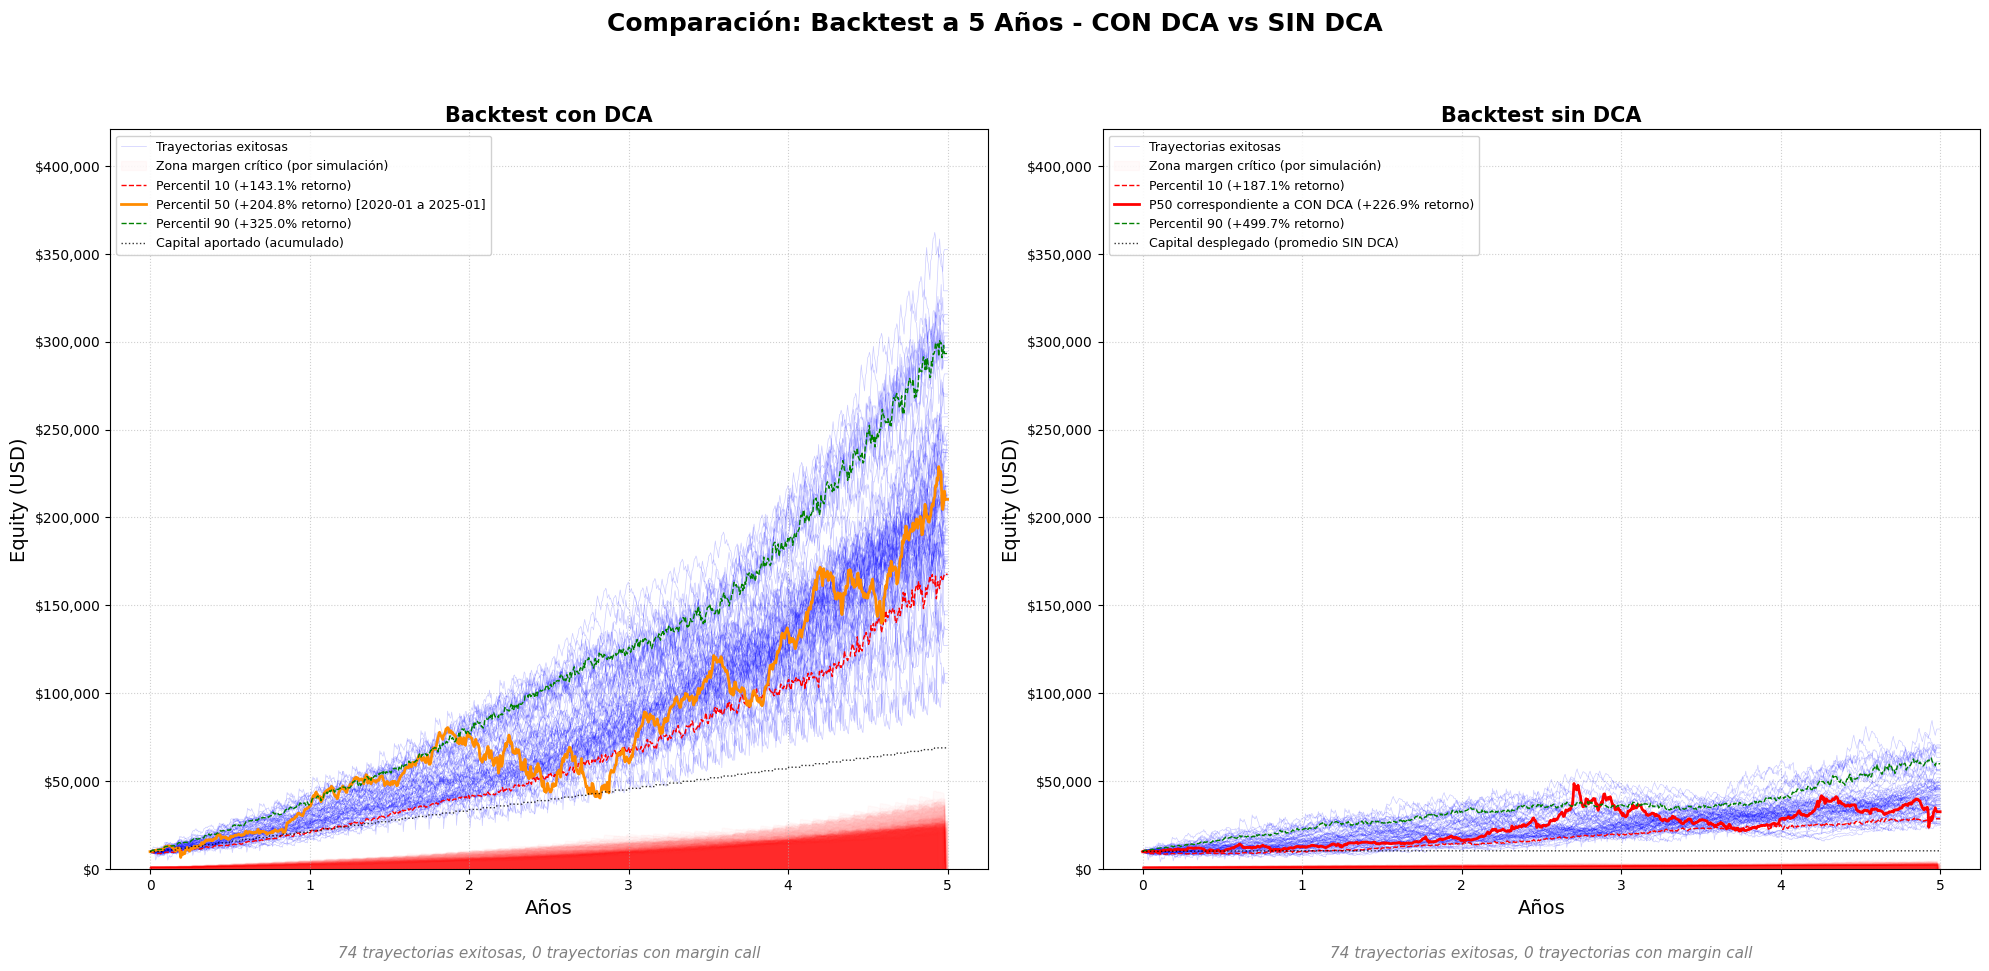

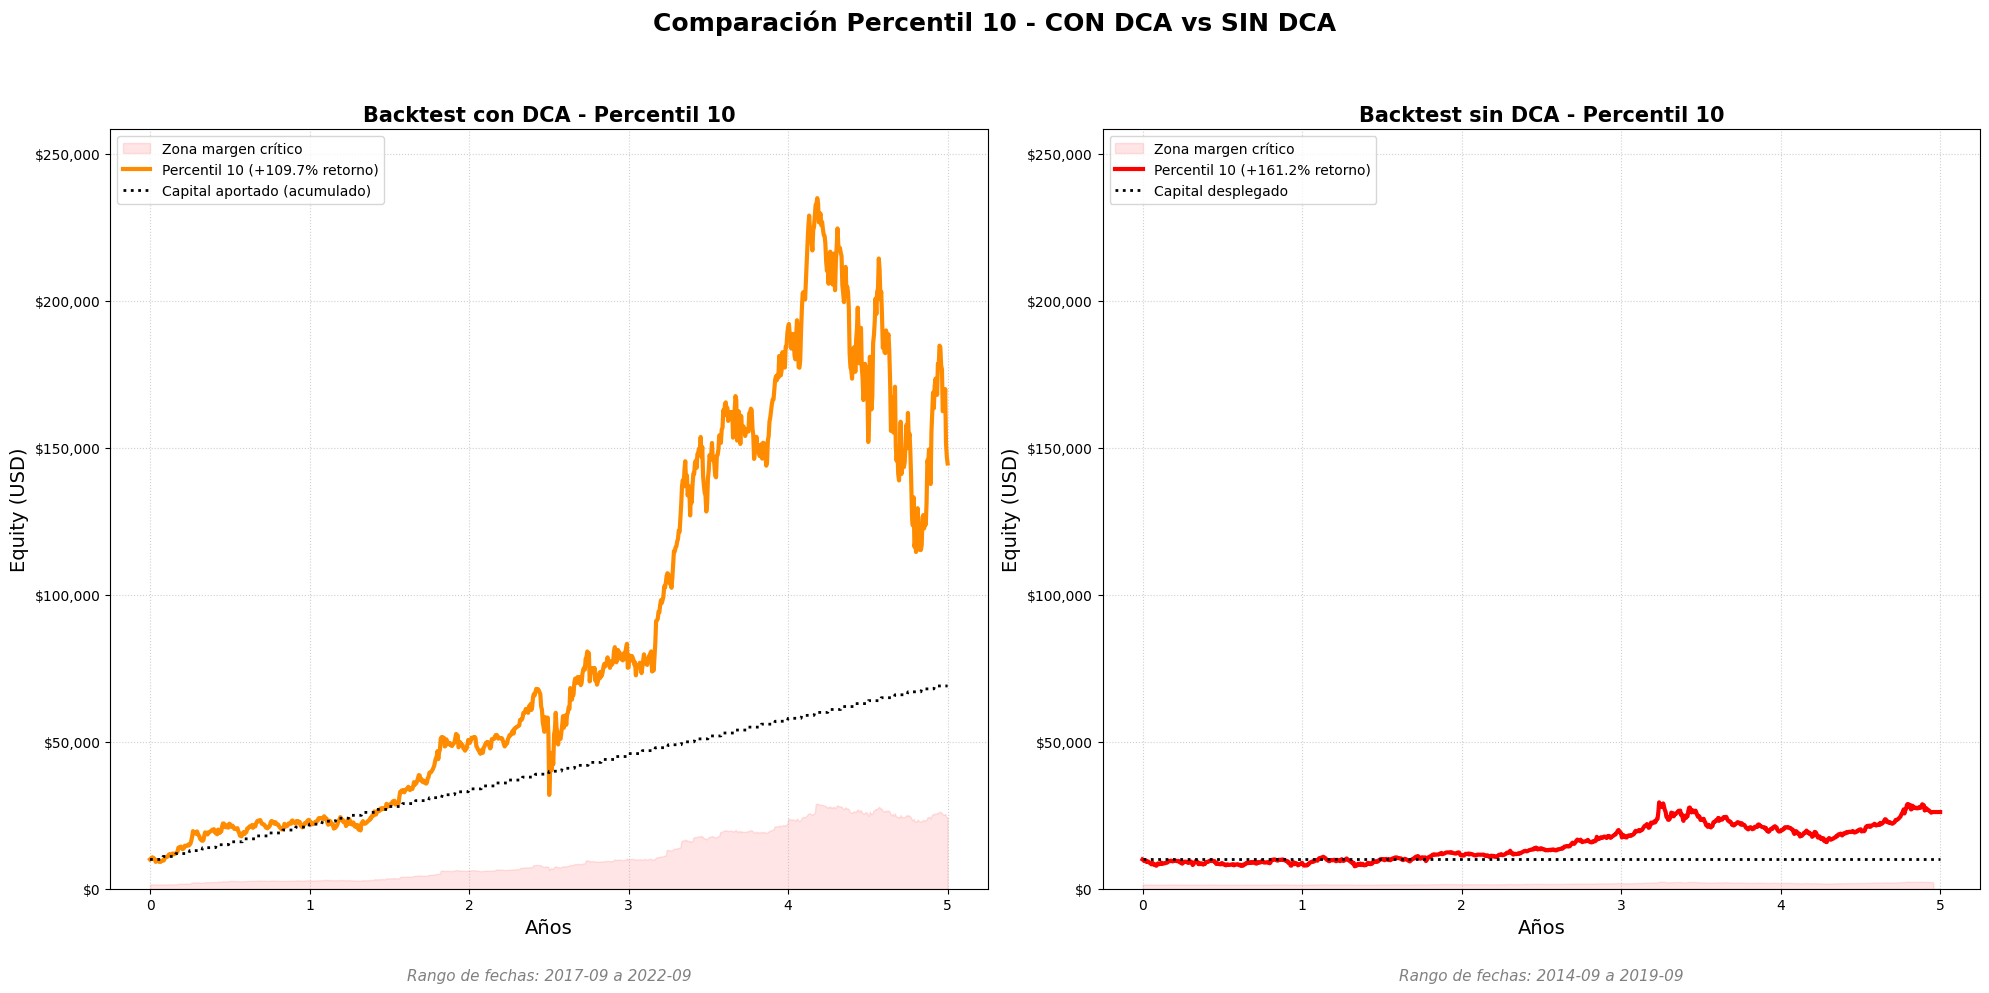

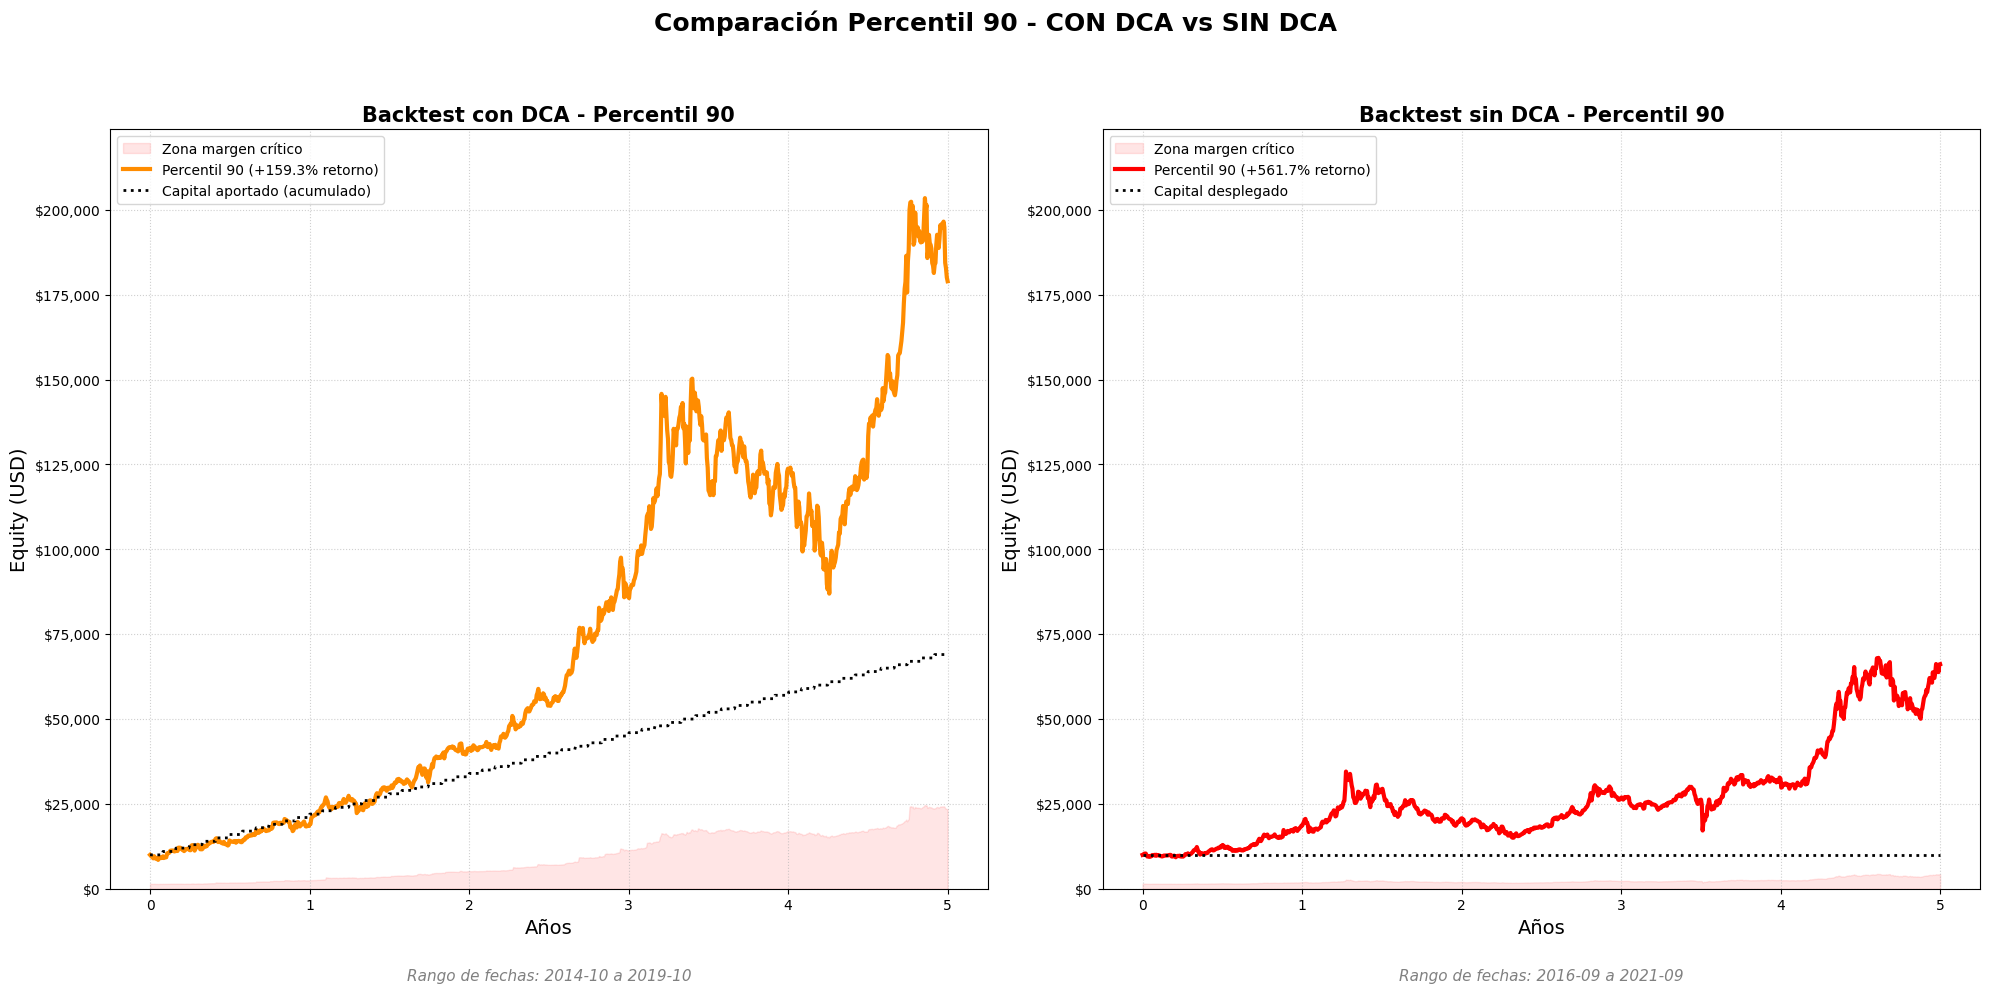


✅ Backtest completo finalizado exitosamente


In [225]:
if len(all_trajectories_with_dca) > 0 and len(all_trajectories_without_dca) > 0:
    # Calculate and plot percentiles
    INITIAL_CAPITAL = METAPARAMETERS["initial_capital"]
    MAINTENANCE_RATIO = METAPARAMETERS["maintenance_margin_ratio"]
    MONTHLY_CONTRIBUTION = METAPARAMETERS["monthly_contribution"]

    print("\n" + "=" * 80)
    print("📊 Generando gráficas con todas las trayectorias...")
    print("=" * 80)

    # Helper function to pad trajectory
    def pad_trajectory(traj, target_length, final_value=None):
        if len(traj) < target_length:
            pad_value = (
                final_value
                if final_value is not None
                else (traj[-1] if len(traj) > 0 else 0)
            )
            return np.pad(
                traj,
                (0, target_length - len(traj)),
                mode="constant",
                constant_values=pad_value,
            )
        else:
            return traj[:target_length]
    
    def calculate_contributed_capital_trajectory(time_points, initial_capital, monthly_contribution, years):
        """Calculate accumulated contributed capital over time for CON DCA (includes initial + monthly contributions)."""
        days_per_month = len(time_points) / (years * 12)
        
        contributed_capital = np.full(len(time_points), initial_capital, dtype=float)
        
        # Add monthly contributions at appropriate time points
        for month in range(1, int(years * 12) + 1):
            day_idx = int(month * days_per_month)
            if day_idx < len(contributed_capital):
                # Add contribution from this day onwards
                for i in range(day_idx, len(contributed_capital)):
                    contributed_capital[i] += monthly_contribution
            else:
                break
        
        return contributed_capital
    
    def calculate_deployed_capital_trajectory(time_points, initial_capital, portfolio_state, years):
        """Calculate deployed capital trajectory for SIN DCA based on actual contributions.
        
        Logic: Starts with initial capital, then adds contributions only when leverage >= max_leverage.
        """
        days_per_month = len(time_points) / (years * 12)
        
        # Start with initial capital everywhere
        deployed_capital = np.full(len(time_points), initial_capital, dtype=float)
        
        if portfolio_state and 'monthly_distributions' in portfolio_state:
            cumulative_deployed = initial_capital
            
            for month_data in portfolio_state['monthly_distributions']:
                month_num = month_data.get('month', 0)
                capital_added = month_data.get('capital_added_to_positions', 0.0)
                
                if month_num > 0 and capital_added > 0:
                    # Calculate day index for this month
                    day_idx = int((month_num - 1) * days_per_month)
                    if day_idx < len(deployed_capital):
                        cumulative_deployed += capital_added
                        # Update from this day onwards with accumulated deployed capital
                        for i in range(day_idx, len(deployed_capital)):
                            deployed_capital[i] = cumulative_deployed
        
        return deployed_capital

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Calculate max length for both datasets
    all_trajectories_combined = (
        all_trajectories_with_dca + all_trajectories_without_dca
    )
    max_length = max(len(traj) for traj in all_trajectories_combined)
    time_points = np.linspace(0, WINDOW_YEARS, max_length)
    
    # Calculate contributed capital trajectory for CON DCA (initial + all monthly contributions)
    contributed_capital_traj = calculate_contributed_capital_trajectory(
        time_points, INITIAL_CAPITAL, MONTHLY_CONTRIBUTION, WINDOW_YEARS
    )

    # Helper function to plot on a specific axis
    def plot_on_axis(
        ax, trajectories, exposures, final_capitals_list, title_prefix, color_scheme, 
        portfolio_states=None, use_sin_dca_deployed=False
    ):
        """Plot trajectories on a specific axis.
        
        Args:
            portfolio_states: List of portfolio states for SIN DCA (to calculate deployed capital)
            use_sin_dca_deployed: If True, calculate deployed capital for SIN DCA
        Returns:
            dict with keys: 'p50_final' (float)
        """
        # Separate trajectories by outcome and keep indices for labeling
        success_trajs = []
        success_exposures = []
        success_indices = []
        margin_call_trajs = []
        for i, (traj, exp, final_cap) in enumerate(zip(trajectories, exposures, final_capitals_list)):
            if final_cap == 0:
                margin_call_trajs.append(traj)
            else:
                success_trajs.append(traj)
                success_exposures.append(exp)
                success_indices.append(i)

        # Plot successful trajectories
        success_labeled = False
        for traj in success_trajs:
            traj_padded = pad_trajectory(traj, max_length)
            label = "Trayectorias exitosas" if not success_labeled else ""
            ax.plot(
                time_points,
                traj_padded,
                alpha=0.2,
                linewidth=0.5,
                color=color_scheme["success"],
                linestyle="-",
                label=label,
            )
            success_labeled = True

        # Plot margin call trajectories
        margin_labeled = False
        for traj in margin_call_trajs:
            traj_padded = pad_trajectory(traj, max_length, final_value=0)
            label = "Trayectorias con margin call" if not margin_labeled else ""
            ax.plot(
                time_points,
                traj_padded,
                alpha=0.6,
                linewidth=0.8,
                color="red",
                linestyle="--",
                label=label,
            )
            margin_labeled = True
        
        if len(success_trajs) > 0:
            success_trajs_array = np.array(
                [pad_trajectory(traj, max_length) for traj in success_trajs]
            )
            success_exposures_array = np.array(
                [pad_trajectory(exp, max_length, final_value=0) for exp in success_exposures]
            )
            
            p10 = np.percentile(success_trajs_array, 10, axis=0)
            p90 = np.percentile(success_trajs_array, 90, axis=0)

            # Select the single trajectory whose final capital is at the 50th percentile (closest)
            success_final_caps = [fc for fc in final_capitals_list if fc > 0]
            if len(success_final_caps) > 0:
                median_capital = np.median(success_final_caps)
                idx_p50 = int(np.argmin(np.abs(np.array(success_final_caps) - median_capital)))
                traj_p50 = pad_trajectory(success_trajs[idx_p50], max_length)
                # Map to original window index for label
                orig_idx = success_indices[idx_p50] if 0 <= idx_p50 < len(success_indices) else None
            else:
                # Fallback to median path if no successful trajectories (edge case)
                traj_p50 = np.percentile(success_trajs_array, 50, axis=0)
                orig_idx = None

            # Calculate critical threshold for EACH trajectory individually
            # Each trajectory has its own exposure, so we calculate threshold per trajectory
            critical_thresholds_array = success_exposures_array * MAINTENANCE_RATIO

            # Plot individual critical threshold areas for each trajectory (no lines, only areas)
            # Each area is semi-transparent, creating a gradient effect when they overlap
            critical_labeled = False
            for i, crit_threshold in enumerate(critical_thresholds_array):
                label = "Zona margen crítico (por simulación)" if not critical_labeled else ""
                ax.fill_between(
                    time_points,
                    0,
                    crit_threshold,
                    color="red",
                    alpha=0.02,
                    label=label,
                )
                critical_labeled = True

            # Calculate returns for percentiles and selected p50 trajectory
            # Use contributed capital (total invested) instead of initial capital
            
            # For SIN DCA, calculate deployed capital for P50 trajectory
            if use_sin_dca_deployed and portfolio_states is not None and orig_idx is not None:
                try:
                    ps_p50 = portfolio_states[orig_idx]
                    deployed_capital_p50 = calculate_deployed_capital_trajectory(
                        time_points, INITIAL_CAPITAL, ps_p50, WINDOW_YEARS
                    )
                    total_invested_final = deployed_capital_p50[-1] if deployed_capital_p50[-1] > 0 else INITIAL_CAPITAL
                except Exception:
                    total_invested_final = contributed_capital_traj[-1] if len(contributed_capital_traj) > 0 else INITIAL_CAPITAL
            else:
                # For CON DCA, use contributed capital trajectory
                total_invested_final = contributed_capital_traj[-1] if len(contributed_capital_traj) > 0 else INITIAL_CAPITAL
            
            p10_return = ((p10[-1] / total_invested_final) - 1) * 100 if total_invested_final > 0 else 0
            p50_return = ((traj_p50[-1] / total_invested_final) - 1) * 100 if total_invested_final > 0 else 0
            p90_return = ((p90[-1] / total_invested_final) - 1) * 100 if total_invested_final > 0 else 0

            # Store p50 final for external scaling
            p50_final_value = float(traj_p50[-1]) if len(traj_p50) > 0 else 0.0
            # Resolve label (YYYY-MM a YYYY-MM) if available
            try:
                p50_label = window_labels[orig_idx] if (orig_idx is not None) else ""
            except Exception:
                p50_label = ""

            ax.plot(
                time_points,
                p10,
                color=color_scheme["p10"],
                linewidth=1,
                linestyle="--",
                #alpha=0.8,
                label=f"Percentil 10 ({p10_return:+.1f}% retorno)",
            )
            # Plot P50 only if we're not in SIN DCA plot (replace with synchronized one)
            if not (title_prefix.lower().find('sin dca') >= 0 and 'idx_p50_with_dca' in globals()):
                ax.plot(
                    time_points,
                    traj_p50,
                    color=color_scheme["p50"],
                    linewidth=2,
                    label=(f"Percentil 50 ({p50_return:+.1f}% retorno) [{p50_label}]" if p50_label else f"Percentil 50 ({p50_return:+.1f}% retorno)"),
                )
            # If we're in SIN DCA plot, plot the synchronized P50
            elif title_prefix.lower().find('sin dca') >= 0 and 'idx_p50_with_dca' in globals():
                traj_sync = pad_trajectory(all_trajectories_without_dca[idx_p50_with_dca], max_length)
                # Calculate total invested for SIN DCA P50 (synchronized with CON DCA)
                try:
                    ps_wo_p50_sync = all_portfolio_states_without_dca[idx_p50_with_dca]
                    deployed_capital_sync = calculate_deployed_capital_trajectory(
                        time_points, INITIAL_CAPITAL, ps_wo_p50_sync, WINDOW_YEARS
                    )
                    total_invested_sync = deployed_capital_sync[-1] if deployed_capital_sync[-1] > 0 else INITIAL_CAPITAL
                except Exception:
                    total_invested_sync = INITIAL_CAPITAL
                
                sync_return = ((traj_sync[-1] / total_invested_sync) - 1) * 100 if total_invested_sync > 0 else 0
                ax.plot(
                    time_points,
                    traj_sync,
                    color="red",
                    linewidth=2,
                    label=f"P50 correspondiente a CON DCA ({sync_return:+.1f}% retorno)",
                )
            ax.plot(
                time_points,
                p90,
                color=color_scheme["p90"],
                linewidth=1,
                linestyle="--",
                #alpha=0.8,
                label=f"Percentil 90 ({p90_return:+.1f}% retorno)",
            )
            


        # Plot capital contribution line
        # For CON DCA: show contributed capital (initial + all monthly contributions)
        # For SIN DCA: show deployed capital (initial + only when leverage >= max_leverage)
        if use_sin_dca_deployed and portfolio_states is not None:
            # Calculate average deployed capital across all SIN DCA trajectories
            try:
                deployed_capital_traj_avg = np.full(len(time_points), INITIAL_CAPITAL, dtype=float)
                valid_count = 0
                
                for ps in portfolio_states:
                    if ps and 'monthly_distributions' in ps:
                        traj_deployed = calculate_deployed_capital_trajectory(
                            time_points, INITIAL_CAPITAL, ps, WINDOW_YEARS
                        )
                        deployed_capital_traj_avg += traj_deployed
                        valid_count += 1
                
                if valid_count > 0:
                    deployed_capital_traj_avg = deployed_capital_traj_avg / valid_count
                    capital_traj_to_plot = deployed_capital_traj_avg
                    capital_label = "Capital desplegado (promedio SIN DCA)"
                else:
                    capital_traj_to_plot = contributed_capital_traj
                    capital_label = "Capital aportado (acumulado)"
            except Exception:
                capital_traj_to_plot = contributed_capital_traj
                capital_label = "Capital aportado (acumulado)"
        else:
            capital_traj_to_plot = contributed_capital_traj
            capital_label = "Capital aportado (acumulado)"
        
        ax.plot(
            time_points,
            capital_traj_to_plot,
            color="black",
            linestyle=":",
            linewidth=1,
            label=capital_label,
            alpha=0.8,
        )

        # Formatting
        ax.set_xlabel("Años", fontsize=14)
        ax.set_ylabel("Equity (USD)", fontsize=14)
        title_text = title_prefix
        ax.set_title(title_text, fontsize=15, fontweight="bold")
        
        # Add subtitle with statistics
        subtitle_text = f"{len(success_trajs)} trayectorias exitosas, {len(margin_call_trajs)} trayectorias con margin call"
        ax.text(0.5, -0.12, subtitle_text, transform=ax.transAxes, 
                fontsize=11, ha='center', style='italic', color='gray')
        
        ax.grid(True, linestyle=":", alpha=0.6)

        # Format y-axis as currency
        currency_formatter = FuncFormatter(lambda value, _: f"${value:,.0f}")
        ax.yaxis.set_major_formatter(currency_formatter)

        # Legend
        ax.legend(loc="upper left", fontsize=9, framealpha=0.9)

        return {"p50_final": p50_final_value}

    # Plot CON DCA on left subplot
    res_left = plot_on_axis(
        ax1,
        all_trajectories_with_dca,
        all_exposures_with_dca,
        final_capitals_with_dca,
        "Backtest con DCA",
        {"success": "blue", "p10": "red", "p50": "darkorange", "p90": "green"},
        portfolio_states=None,
        use_sin_dca_deployed=False
    )

    # Plot SIN DCA on right subplot
    res_right = plot_on_axis(
        ax2,
        all_trajectories_without_dca,
        all_exposures_without_dca,
        final_capitals_without_dca,
        "Backtest sin DCA",
        {"success": "blue", "p10": "red", "p50": "darkorange", "p90": "green"},
        portfolio_states=all_portfolio_states_without_dca,
        use_sin_dca_deployed=True
    )

    # Calculate max equity across both datasets based on 2x of p50 final
    p50_left = res_left.get("p50_final", 0.0) if isinstance(res_left, dict) else 0.0
    p50_right = res_right.get("p50_final", 0.0) if isinstance(res_right, dict) else 0.0
    max_equity_both = max(p50_left, p50_right) * 2 if max(p50_left, p50_right) > 0 else 1.0

    ax1.set_ylim(0, max_equity_both)
    ax2.set_ylim(0, max_equity_both)

    # Add overall title
    fig.suptitle(
        "Comparación: Backtest a 5 Años - CON DCA vs SIN DCA",
        fontsize=18,
        fontweight="bold",
        y=1.02,
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    fig_path = os.path.join(SNAPSHOTS_DIR, "all_trajectories_comparison.png")
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()

    # Helper function to plot percentile-specific comparison
    def plot_percentile_comparison(traj_with, exp_with, traj_without, exp_without, 
                                   ps_with, ps_without, idx_with, idx_without,
                                   percentile_label, percentile_short):
        """Plot comparison for a specific percentile."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        max_len = max(len(traj_with), len(traj_without))
        time_pts = np.linspace(0, WINDOW_YEARS, max_len)
        
        traj_with_p = pad_trajectory(traj_with, max_len)
        exp_with_p = pad_trajectory(exp_with, max_len, final_value=0)
        traj_without_p = pad_trajectory(traj_without, max_len)
        exp_without_p = pad_trajectory(exp_without, max_len, final_value=0)
        
        # CON DCA capital
        capital_with = calculate_contributed_capital_trajectory(
            time_pts, INITIAL_CAPITAL, MONTHLY_CONTRIBUTION, WINDOW_YEARS
        )
        
        # SIN DCA deployed capital
        try:
            ps_wo = ps_without[idx_without] if idx_without < len(ps_without) else None
            capital_without = calculate_deployed_capital_trajectory(
                time_pts, INITIAL_CAPITAL, ps_wo, WINDOW_YEARS
            ) if ps_wo else capital_with
        except Exception:
            capital_without = capital_with
        
        # Returns
        ret_with = ((traj_with_p[-1] / capital_with[-1]) - 1) * 100 if capital_with[-1] > 0 else 0
        ret_without = ((traj_without_p[-1] / capital_without[-1]) - 1) * 100 if capital_without[-1] > 0 else 0
        
        # Critical thresholds
        crit_with = exp_with_p * MAINTENANCE_RATIO
        crit_without = exp_without_p * MAINTENANCE_RATIO
        
        # Get window labels for subtitle
        label_with = ""
        label_without = ""
        try:
            label_with = window_labels[idx_with] if idx_with < len(window_labels) else ""
        except Exception:
            pass
        try:
            label_without = window_labels[idx_without] if idx_without < len(window_labels) else ""
        except Exception:
            pass
        
        # CON DCA plot
        ax1.fill_between(time_pts, 0, crit_with, color='red', alpha=0.1, label='Zona margen crítico')
        ax1.plot(time_pts, traj_with_p, color='darkorange', linewidth=3, 
                 label=f'{percentile_label} ({ret_with:+.1f}% retorno)')
        ax1.plot(time_pts, capital_with, color='black', linestyle=':', linewidth=2,
                 label='Capital aportado (acumulado)')
        ax1.set_title(f'Backtest con DCA - {percentile_label}', fontsize=15, fontweight='bold')
        if label_with:
            ax1.text(0.5, -0.12, f'Rango de fechas: {label_with}', transform=ax1.transAxes, 
                    fontsize=11, ha='center', style='italic', color='gray')
        ax1.set_xlabel('Años', fontsize=14)
        ax1.set_ylabel('Equity (USD)', fontsize=14)
        ax1.grid(True, linestyle=':', alpha=0.6)
        ax1.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
        ax1.legend(loc='upper left', fontsize=10)
        
        # SIN DCA plot
        ax2.fill_between(time_pts, 0, crit_without, color='red', alpha=0.1, label='Zona margen crítico')
        ax2.plot(time_pts, traj_without_p, color='red', linewidth=3,
                 label=f'{percentile_label} ({ret_without:+.1f}% retorno)')
        ax2.plot(time_pts, capital_without, color='black', linestyle=':', linewidth=2,
                 label='Capital desplegado')
        ax2.set_title(f'Backtest sin DCA - {percentile_label}', fontsize=15, fontweight='bold')
        if label_without:
            ax2.text(0.5, -0.12, f'Rango de fechas: {label_without}', transform=ax2.transAxes, 
                    fontsize=11, ha='center', style='italic', color='gray')
        ax2.set_xlabel('Años', fontsize=14)
        ax2.set_ylabel('Equity (USD)', fontsize=14)
        ax2.grid(True, linestyle=':', alpha=0.6)
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
        ax2.legend(loc='upper left', fontsize=10)
        
        # Sync y-axis
        max_val = max(traj_with_p.max(), traj_without_p.max()) * 1.1
        ax1.set_ylim(0, max_val)
        ax2.set_ylim(0, max_val)
        
        fig.suptitle(f'Comparación {percentile_label} - CON DCA vs SIN DCA', 
                     fontsize=18, fontweight='bold', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        # Save figure
        fig_path = os.path.join(SNAPSHOTS_DIR, f"comparison_{percentile_short}.png")
        fig.savefig(fig_path, dpi=150, bbox_inches='tight')
        plt.show()

    # Plot P10 comparison
    if 'trajectory_p10_with_dca' in locals() and 'trajectory_p10_without_dca' in locals():
        plot_percentile_comparison(
            trajectory_p10_with_dca, exposure_p10_with_dca,
            trajectory_p10_without_dca, exposure_p10_without_dca,
            all_portfolio_states_with_dca, all_portfolio_states_without_dca,
            idx_p10_with_dca, idx_p10_without_dca,
            'Percentil 10', 'P10'
        )

    # Plot P90 comparison
    if 'trajectory_p90_with_dca' in locals() and 'trajectory_p90_without_dca' in locals():
        plot_percentile_comparison(
            trajectory_p90_with_dca, exposure_p90_with_dca,
            trajectory_p90_without_dca, exposure_p90_without_dca,
            all_portfolio_states_with_dca, all_portfolio_states_without_dca,
            idx_p90_with_dca, idx_p90_without_dca,
            'Percentil 90', 'P90'
        )

    print("\n✅ Backtest completo finalizado exitosamente")
else:
    print("\n❌ No se pudieron generar backtests. Verifica los datos.")

## 🧪 Single Simulation

Esta sección permite ejecutar una única simulación de backtest empezando en un año y mes concretos, durante un número de años configurable.

- Configura los parámetros en la siguiente celda (año, mes, años, CON/SIN DCA).
- Ejecuta la tercera celda para correr la simulación y visualizar:
  - Trayectoria de equity
  - Línea de capital inicial
  - Área de margen crítico (liquidación) basada en exposición × maintenance ratio
- Se imprimen métricas rápidas: Capital Final, Total Aportado, Retorno Absoluto y Retorno Total (%).

In [226]:
# Configuration parameters for Single Simulation
SINGLE_YEAR = 2020      # Start year (e.g., 2020)
SINGLE_MONTH = 2        # Start month [1-12]
SINGLE_YEARS = 5        # Simulation duration in years

In [227]:
def run_single_simulation_by_year_month(
                year: int, 
                month: int, 
                years: int = None, 
                enable_dca: bool = True
    ):
    """
    Run a single backtest simulation starting at a specific calendar year and month.

    Args:
        year: Start year (e.g., 2020)
        month: Start month [1-12]
        years: Number of years to simulate. If None, uses WINDOW_YEARS if defined, else 5.
        enable_dca: Whether to enable DCA logic (True for CON DCA, False for SIN DCA)

    Returns:
        result: Dict with keys: 'portfolio_state', 'trajectory', 'exposure', 'start_date', 'end_date'
    """
    # Resolve default years if not provided
    sim_years = years if years is not None else (WINDOW_YEARS if 'WINDOW_YEARS' in globals() else 5)

    # Ensure we have historical returns DataFrame in scope
    if 'log_returns_full' not in globals() or not isinstance(log_returns_full, pd.DataFrame):
        raise RuntimeError("log_returns_full is not available. Run data loading cells first.")

    # Build start and end timestamps
    start_candidate = pd.Timestamp(year=int(year), month=int(month), day=1)
    end_candidate = start_candidate + pd.DateOffset(years=int(sim_years))

    # Align start to existing index (first available date on/after the candidate)
    idx_sorted = log_returns_full.index.sort_values()
    valid_starts = idx_sorted[idx_sorted >= start_candidate]
    if len(valid_starts) == 0:
        raise ValueError("Selected start date is after available data range.")
    start_date = valid_starts[0]

    # End date: limit by available data
    end_date = min(end_candidate, idx_sorted[-1])

    # Slice returns
    mask = (idx_sorted >= start_date) & (idx_sorted <= end_date)
    returns_slice = log_returns_full.loc[mask]
    if returns_slice.empty:
        raise ValueError("No data available for the selected period.")

    # Determine asset universe/intersection
    asset_names = list(PORTFOLIO_OPTIMIZED.keys()) if 'PORTFOLIO_OPTIMIZED' in globals() else list(returns_slice.columns)
    available_assets = [a for a in asset_names if a in returns_slice.columns]
    if len(available_assets) == 0:
        raise ValueError("None of the optimized assets are present in returns data slice.")

    # Build weights array aligned to available assets
    weights_series = pd.Series(PORTFOLIO_OPTIMIZED)[available_assets]
    weights_array = weights_series.values
    weights_array = weights_array / np.sum(weights_array)

    # Backtest run requires DataFrame of daily log returns aligned with asset_names
    daily_returns_df = returns_slice[available_assets].copy()

    # Execute the backtest using existing engine
    portfolio_state = run_backtest(
        daily_returns_df,
        available_assets,
        weights_array,
        enable_dca=enable_dca,
        verbose=True,
    )

    # Extract outputs
    trajectory = np.array(portfolio_state["daily_equity"]) if "daily_equity" in portfolio_state else np.array([])
    exposure = np.array(portfolio_state["daily_exposure"]) if "daily_exposure" in portfolio_state else np.array([])

    # Compute total capital contributed (sum of negative cash flows as positive value)
    cash_flows = portfolio_state.get("cash_flow_history", [])
    total_invested = -float(np.sum([cf for cf in cash_flows if cf < 0])) if len(cash_flows) > 0 else 0.0

    return {
        "portfolio_state": portfolio_state,
        "trajectory": trajectory,
        "exposure": exposure,
        "start_date": start_date,
        "end_date": end_date,
        "total_invested": total_invested,
    }

#PORTFOLIO_OPTIMIZED = PORTFOLIO_INITIAL.copy()

# 🔄 Ejecución Single Simulation (CON y SIN DCA)
results_single_with_dca = run_single_simulation_by_year_month(
    SINGLE_YEAR, SINGLE_MONTH, years=SINGLE_YEARS, enable_dca=True
)
results_single_without_dca = run_single_simulation_by_year_month(
    SINGLE_YEAR, SINGLE_MONTH, years=SINGLE_YEARS, enable_dca=False
)




💰 Inicializando cartera
Capital inicial: $10,000
Leverage objetivo: 3x
Trading Power inicial: $30,000
✅ Backtest completado sin margin calls
   Capital final: $223,159

💰 Inicializando cartera
Capital inicial: $10,000
Leverage objetivo: 3x
Trading Power inicial: $30,000
✅ Backtest completado sin margin calls
   Capital final: $46,335


# 📊 Métricas avanzadas de comparación para una sola simulación

Calculamos métricas detalladas para la trayectoria de ambas estrategias.


In [228]:
# 📊 Advanced comparison metrics for a single simulation

def _sanitize_trajectory(traj: np.ndarray, fallback_initial: float) -> np.ndarray:
    traj = np.array(traj, dtype=float)
    if traj.ndim != 1:
        traj = traj.flatten()
    # Replace non-finite or <= 0 with NaN, then forward-fill
    invalid = ~np.isfinite(traj) | (traj <= 0)
    if np.all(invalid):
        return np.array([fallback_initial, fallback_initial], dtype=float)
    traj[invalid] = np.nan
    # Forward-fill NaNs
    if np.isnan(traj[0]):
        traj[0] = fallback_initial
    for i in range(1, len(traj)):
        if np.isnan(traj[i]):
            traj[i] = traj[i-1]
    # Ensure at least 2 points
    if len(traj) < 2:
        traj = np.array([fallback_initial, traj[-1] if len(traj) else fallback_initial], dtype=float)
    return traj

def calculate_contributed_capital_trajectory(time_points, initial_capital, monthly_contribution, years):
    """
    Calculate accumulated contributed capital over time for CON DCA (includes initial + monthly contributions).
    """
    days_per_month = len(time_points) / (years * 12) if years > 0 else len(time_points) / 12
    
    contributed_capital = np.full(len(time_points), initial_capital, dtype=float)
    
    # Add monthly contributions at appropriate time points
    for month in range(1, int(years * 12) + 1):
        day_idx = int(month * days_per_month)
        if day_idx < len(contributed_capital):
            # Add contribution from this day onwards
            for i in range(day_idx, len(contributed_capital)):
                contributed_capital[i] += monthly_contribution
        else:
            break
    
    return contributed_capital

def calculate_deployed_capital_trajectory(time_points, initial_capital, portfolio_state, years):
    """
    Calculate deployed capital trajectory for SIN DCA based on actual contributions.
    
    Logic: Starts with initial capital, then adds contributions only when leverage >= max_leverage.
    """
    days_per_month = len(time_points) / (years * 12) if years > 0 else len(time_points) / 12
    
    # Start with initial capital everywhere
    deployed_capital = np.full(len(time_points), initial_capital, dtype=float)
    
    if portfolio_state and 'monthly_distributions' in portfolio_state:
        cumulative_deployed = initial_capital
        
        for month_data in portfolio_state['monthly_distributions']:
            month_num = month_data.get('month', 0)
            capital_added = month_data.get('capital_added_to_positions', 0.0)
            
            if month_num > 0 and capital_added > 0:
                # Calculate day index for this month
                day_idx = int((month_num - 1) * days_per_month)
                if day_idx < len(deployed_capital):
                    cumulative_deployed += capital_added
                    # Update from this day onwards
                    for i in range(day_idx, len(deployed_capital)):
                        deployed_capital[i] = cumulative_deployed
                else:
                    break
    
    return deployed_capital

def calculate_margin_call_metrics(trajectory, exposure):
    """
    Calculate margin call proximity metrics.
    
    Args:
        trajectory: Array of daily equity values
        exposure: Array of daily exposure values
        
    Returns:
        dict: Dictionary with margin call metrics
    """
    if exposure is None or len(exposure) != len(trajectory):
        return {
            'min_margin_buffer_pct': np.nan,
            'min_margin_ratio': np.nan,
            'days_under_critical_margin': np.nan,
            'time_under_critical_margin_pct': np.nan,
            'survival_days': len(trajectory),
            'margin_call_occurred': False,
            'min_drawdown_to_margin_call': np.nan
        }
    
    MAINTENANCE_MARGIN_RATIO = METAPARAMETERS['maintenance_margin_ratio']
    CRITICAL_MARGIN_RATIO = METAPARAMETERS.get('critical_margin_ratio', 0.10)
    
    # Calculate margin ratio for each day (equity / exposure)
    margin_ratios = np.array([
        trajectory[i] / exposure[i] if exposure[i] > 0 else 1.0
        for i in range(len(trajectory))
    ])
    
    # Margin buffer: difference between current margin and maintenance threshold
    margin_buffers = margin_ratios - MAINTENANCE_MARGIN_RATIO
    min_margin_buffer = np.min(margin_buffers)
    min_margin_ratio = np.min(margin_ratios)
    
    # Days under critical margin threshold
    days_under_critical = np.sum(margin_ratios < CRITICAL_MARGIN_RATIO)
    
    # Survival time: days until margin call (if occurred) or total days if survived
    margin_call_day = None
    for i in range(len(trajectory)):
        if margin_ratios[i] <= MAINTENANCE_MARGIN_RATIO or trajectory[i] <= 0:
            margin_call_day = i
            break
    
    # Drawdown to margin call threshold: how much more can equity drop before margin call
    drawdown_to_threshold = np.zeros(len(trajectory))
    for i in range(len(trajectory)):
        if trajectory[i] > 0 and exposure[i] > 0:
            threshold_equity = exposure[i] * MAINTENANCE_MARGIN_RATIO
            if threshold_equity < trajectory[i]:
                drawdown_to_threshold[i] = (trajectory[i] - threshold_equity) / trajectory[i]
            else:
                drawdown_to_threshold[i] = 0.0
        else:
            drawdown_to_threshold[i] = 0.0
    
    min_drawdown_to_threshold = np.min(drawdown_to_threshold)
    
    return {
        'min_margin_buffer_pct': min_margin_buffer * 100,
        'min_margin_ratio': min_margin_ratio * 100,
        'days_under_critical_margin': days_under_critical,
        'time_under_critical_margin_pct': (days_under_critical / len(trajectory)) * 100,
        'survival_days': margin_call_day if margin_call_day is not None else len(trajectory),
        'margin_call_occurred': margin_call_day is not None,
        'min_drawdown_to_margin_call': min_drawdown_to_threshold * 100
    }

def _compute_metrics_direct(res, enable_dca=True):
    initial_cap = float(METAPARAMETERS['initial_capital'])
    monthly_contrib = float(METAPARAMETERS['monthly_contribution'])
    years = float(SINGLE_YEARS) if SINGLE_YEARS and SINGLE_YEARS > 0 else max(1.0, len(res.get('trajectory', [])) / 252.0)

    equity = _sanitize_trajectory(res.get('trajectory', np.array([])), initial_cap)

    # Returns series
    r = pd.Series(equity).pct_change().replace([np.inf, -np.inf], np.nan).dropna()

    final_capital = float(equity[-1]) if len(equity) else initial_cap

    # Total invested: prefer from result if provided
    total_invested = float(res.get('total_invested', 0.0))
    if total_invested <= 0:
        # Approx fallback: initial + monthly contributions inferred by length in trading days converted to months
        est_months = max(0, int(round(len(equity) / (252/12))))
        total_invested = initial_cap + monthly_contrib * est_months

    absolute_return = final_capital - total_invested
    total_return_pct = (absolute_return / total_invested * 100.0) if total_invested > 0 else 0.0

    # CAGR
    cagr_pct = 0.0
    if initial_cap > 0 and years > 0 and final_capital > 0:
        cagr_pct = ((final_capital / initial_cap) ** (1.0 / years) - 1.0) * 100.0

    # Volatility annualized
    vol_annual_pct = (r.std() * np.sqrt(252) * 100.0) if len(r) > 0 else 0.0

    # Drawdowns (relative to peak equity)
    eq = pd.Series(equity).replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
    rolling_max = eq.cummax()
    dd = (eq / rolling_max) - 1.0
    dd = dd.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    max_drawdown_pct = float(dd.min() * 100.0) if len(dd) > 0 else 0.0
    avg_drawdown_pct = float(dd[dd < 0].mean() * 100.0) if (dd < 0).any() else 0.0
    
    # Days underwater: days where equity < invested capital accumulated
    time_points = np.arange(len(equity))
    if enable_dca:
        # CON DCA: initial + monthly contributions accumulated
        invested_capital_traj = calculate_contributed_capital_trajectory(
            time_points, initial_cap, monthly_contrib, years
        )
    else:
        # SIN DCA: initial + contributions only when leverage >= max_leverage
        portfolio_state = res.get('portfolio_state', {})
        invested_capital_traj = calculate_deployed_capital_trajectory(
            time_points, initial_cap, portfolio_state, years
        )
    
    # Compare equity with invested capital trajectory
    equity_series = pd.Series(equity)
    invested_series = pd.Series(invested_capital_traj)
    days_underwater = int((equity_series < invested_series).sum()) if len(equity_series) == len(invested_series) else 0
    time_underwater_pct = (days_underwater / len(equity_series) * 100.0) if len(equity_series) > 0 else 0.0

    # Ratios (rf assumed 0)
    sharpe_ratio = float((r.mean() * 252) / (r.std() * np.sqrt(252))) if (len(r) > 1 and r.std() > 0) else 0.0
    downside = r[r < 0].std() * np.sqrt(252) if len(r[r < 0]) > 0 else 0.0
    sortino_ratio = float((r.mean() * 252) / downside) if downside and downside > 0 else 0.0
    calmar_ratio = float((cagr_pct / 100.0) / abs(max_drawdown_pct / 100.0)) if max_drawdown_pct != 0 else 0.0

    # Get exposure trajectory for margin call metrics
    exposure_traj = res.get('exposure', None)
    if exposure_traj is not None:
        exposure_traj = np.array(exposure_traj)
        if len(exposure_traj) == len(equity):
            margin_metrics = calculate_margin_call_metrics(equity, exposure_traj)
        else:
            margin_metrics = calculate_margin_call_metrics(equity, None)
    else:
        margin_metrics = calculate_margin_call_metrics(equity, None)

    return {
        'final_capital': final_capital,
        'total_invested': total_invested,
        'absolute_return': absolute_return,
        'total_return_pct': total_return_pct,
        'cagr_pct': cagr_pct,
        'volatility_annual_pct': vol_annual_pct,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'calmar_ratio': calmar_ratio,
        'max_drawdown_pct': max_drawdown_pct,
        'avg_drawdown_pct': avg_drawdown_pct,
        'days_underwater': days_underwater,
        'time_underwater_pct': time_underwater_pct,
        **margin_metrics
    }

metrics_single_with = _compute_metrics_direct(results_single_with_dca, enable_dca=True)
metrics_single_without = _compute_metrics_direct(results_single_without_dca, enable_dca=False)

# Ajuste SIN DCA: contar solo el capital desplegado (excluir buffer)
try:
    ps_wo = results_single_without_dca.get('portfolio_state', {})
    monthly = ps_wo.get('monthly_distributions', []) if isinstance(ps_wo, dict) else []
    total_deployed_wo = float(sum(md.get('capital_added_to_positions', 0.0) for md in monthly))
    initial_cap = float(METAPARAMETERS['initial_capital'])
    total_invested_wo = initial_cap + total_deployed_wo
    final_cap_wo = metrics_single_without.get('final_capital', 0.0)
    metrics_single_without['total_invested'] = total_invested_wo
    metrics_single_without['absolute_return'] = final_cap_wo - total_invested_wo
    metrics_single_without['total_return_pct'] = ((final_cap_wo / total_invested_wo) - 1.0) * 100.0 if total_invested_wo > 0 else 0.0
except Exception:
    pass

# Tabla comparativa similar al resto del notebook
metric_labels = {
    'final_capital': 'Capital Final',
    'total_invested': 'Total Invertido',
    'absolute_return': 'Retorno Absoluto',
    'total_return_pct': 'Retorno Total (%)',
    'cagr_pct': 'CAGR (%)',
    'volatility_annual_pct': 'Volatilidad Anual (%)',
    'sharpe_ratio': 'Sharpe Ratio',
    'sortino_ratio': 'Sortino Ratio',
    'calmar_ratio': 'Calmar Ratio',
    'max_drawdown_pct': 'Max Drawdown (%)',
    'avg_drawdown_pct': 'Drawdown Promedio (%)',
    'days_underwater': 'Días Bajo el Agua',
    'time_underwater_pct': 'Tiempo Bajo el Agua (%)',
    'min_margin_buffer_pct': 'Margen Mínimo Buffer (%)',
    'min_margin_ratio': 'Margen Mínimo (%)',
    'days_under_critical_margin': 'Días Bajo Margen Crítico',
    'time_under_critical_margin_pct': 'Tiempo Bajo Margen Crítico (%)',
    'survival_days': 'Días de Supervivencia',
    'min_drawdown_to_margin_call': 'Drawdown Mínimo al Margin Call (%)',
}

rows = []
for key, label in metric_labels.items():
    val_with = metrics_single_with.get(key, np.nan)
    val_without = metrics_single_without.get(key, np.nan)
    diff = (val_with - val_without) if (isinstance(val_with, (int,float)) and isinstance(val_without, (int,float))) else np.nan
    diff_pct = (diff / val_without * 100.0) if (isinstance(val_without, (int,float)) and val_without not in [0, np.nan]) else np.nan
    rows.append([label, val_with, val_without, diff, diff_pct])

df_metrics = pd.DataFrame(rows, columns=["Métrica", "CON DCA", "SIN DCA", "Diferencia", "Diferencia %"]) 
# Formato simple
pd.options.display.float_format = '{:,.2f}'.format
print("\n" + "=" * 80)
print("📊 TABLA COMPARATIVA DE MÉTRICAS (Single Simulation)")
print("=" * 80)
print(df_metrics.to_string(index=False))


📊 TABLA COMPARATIVA DE MÉTRICAS (Single Simulation)
                           Métrica    CON DCA   SIN DCA  Diferencia  Diferencia %
                     Capital Final 223,159.16 46,335.34  176,823.82        381.62
                   Total Invertido  69,000.00 11,000.00   58,000.00        527.27
                  Retorno Absoluto 154,159.16 35,335.34  118,823.82        336.27
                 Retorno Total (%)     223.42    321.23      -97.81        -30.45
                          CAGR (%)      86.09     35.89       50.20        139.88
             Volatilidad Anual (%)      64.68     60.03        4.65          7.74
                      Sharpe Ratio       1.56      0.97        0.59         61.01
                     Sortino Ratio       2.10      1.20        0.90         74.66
                      Calmar Ratio       1.59      0.57        1.02        178.57
                  Max Drawdown (%)     -54.21    -62.95        8.74        -13.89
             Drawdown Promedio (%)     -11.58

/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_31853/3661247999.py:175: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eq = pd.Series(equity).replace([np.inf, -np.inf], np.nan).fillna(method='ffill')


# 📈 Visualización de resultados para una sola simulación

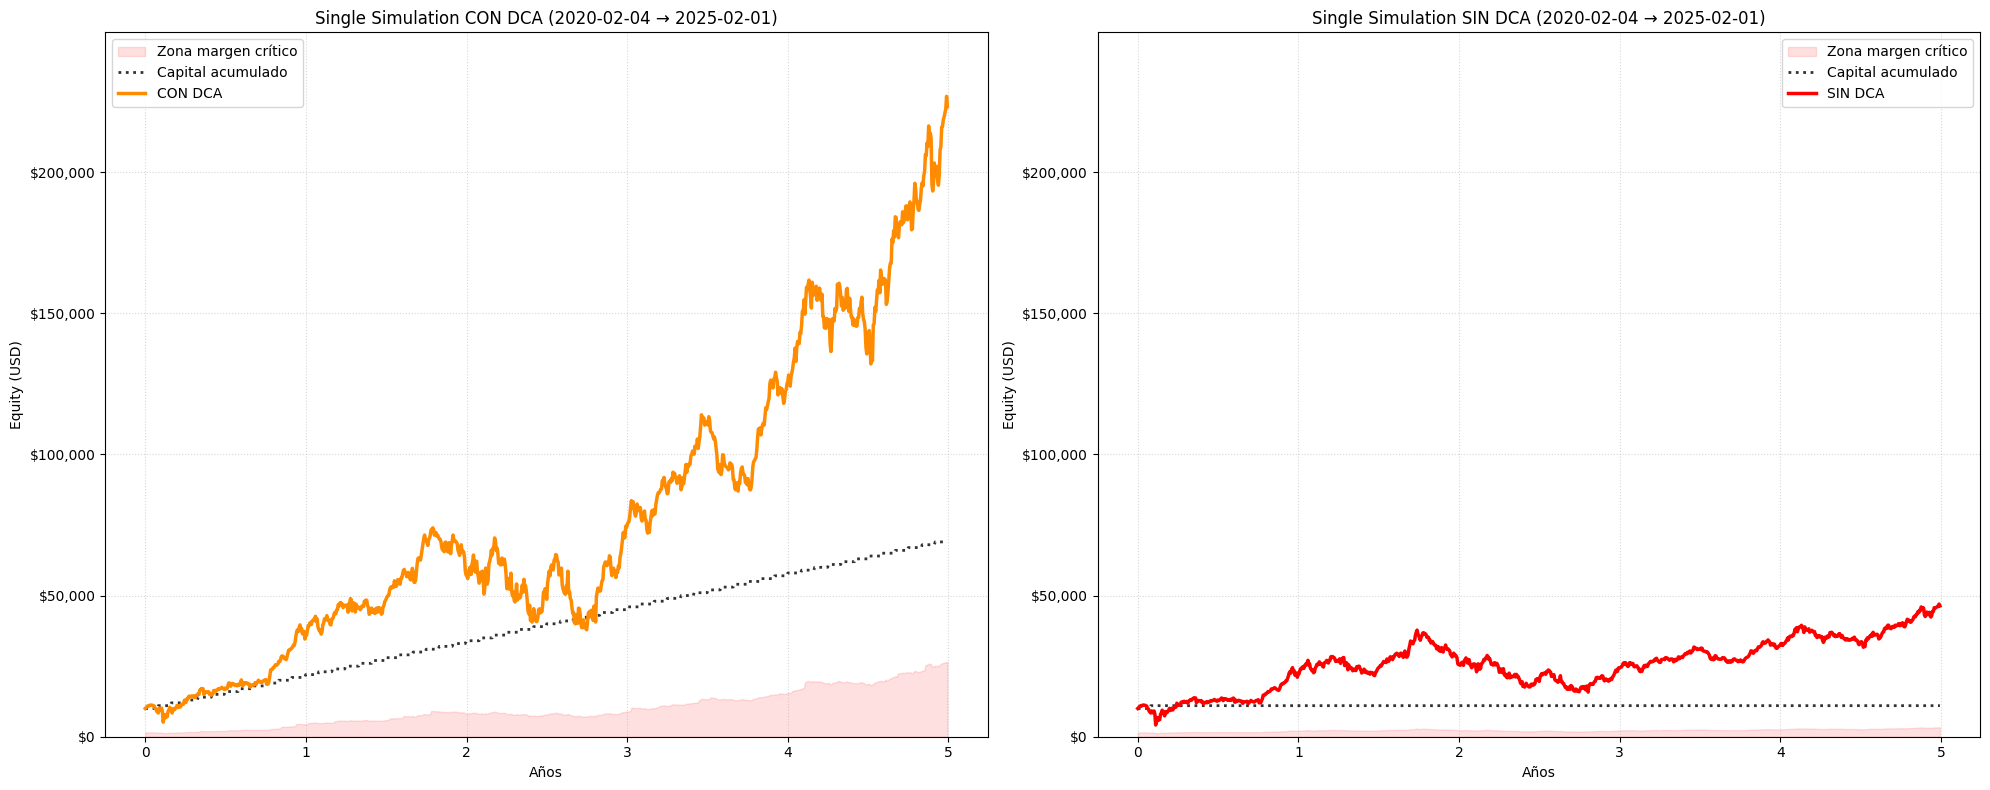

In [229]:
# 📈 Visualization - Single Simulation (WITH vs WITHOUT DCA)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Data
traj_w = results_single_with_dca['trajectory']
expo_w = results_single_with_dca['exposure']
crit_w = expo_w * METAPARAMETERS['maintenance_margin_ratio'] if len(expo_w) == len(traj_w) else np.zeros_like(traj_w)

traj_wo = results_single_without_dca['trajectory']
expo_wo = results_single_without_dca['exposure']
crit_wo = expo_wo * METAPARAMETERS['maintenance_margin_ratio'] if len(expo_wo) == len(traj_wo) else np.zeros_like(traj_wo)

# Time axis (years)
start_dt = min(results_single_with_dca['start_date'], results_single_without_dca['start_date'])
end_dt = max(results_single_with_dca['end_date'], results_single_without_dca['end_date'])
t_w = np.linspace(0, (results_single_with_dca['end_date'] - results_single_with_dca['start_date']).days / 365.25, len(traj_w))
t_wo = np.linspace(0, (results_single_without_dca['end_date'] - results_single_without_dca['start_date']).days / 365.25, len(traj_wo))

# Calculate years for trajectories
years_w = (results_single_with_dca['end_date'] - results_single_with_dca['start_date']).days / 365.25
years_wo = (results_single_without_dca['end_date'] - results_single_without_dca['start_date']).days / 365.25

# Calculate capital accumulated trajectories
time_points_w = np.arange(len(traj_w))
contributed_capital_w = calculate_contributed_capital_trajectory(
    time_points_w, METAPARAMETERS['initial_capital'], METAPARAMETERS['monthly_contribution'], years_w
)

time_points_wo = np.arange(len(traj_wo))
portfolio_state_wo = results_single_without_dca.get('portfolio_state', {})
deployed_capital_wo = calculate_deployed_capital_trajectory(
    time_points_wo, METAPARAMETERS['initial_capital'], portfolio_state_wo, years_wo
)

# Subplot WITH DCA
ax1.fill_between(t_w, 0, crit_w, color='red', alpha=0.12, label='Zona margen crítico')
ax1.plot(t_w, contributed_capital_w, color='black', linestyle=':', linewidth=2, alpha=0.8, label='Capital acumulado')
ax1.plot(t_w, traj_w, color='darkorange', linewidth=2.5, label='CON DCA')
ax1.set_title(f"Single Simulation CON DCA ({results_single_with_dca['start_date'].date()} → {results_single_with_dca['end_date'].date()})")
ax1.set_xlabel('Años')
ax1.set_ylabel('Equity (USD)')
ax1.grid(True, linestyle=':', alpha=0.5)
ax1.legend()

# Subplot WITHOUT DCA
ax2.fill_between(t_wo, 0, crit_wo, color='red', alpha=0.12, label='Zona margen crítico')
ax2.plot(t_wo, deployed_capital_wo, color='black', linestyle=':', linewidth=2, alpha=0.8, label='Capital acumulado')
ax2.plot(t_wo, traj_wo, color='red', linewidth=2.5, label='SIN DCA')
ax2.set_title(f"Single Simulation SIN DCA ({results_single_without_dca['start_date'].date()} → {results_single_without_dca['end_date'].date()})")
ax2.set_xlabel('Años')
ax2.set_ylabel('Equity (USD)')
ax2.grid(True, linestyle=':', alpha=0.5)
ax2.legend()

# Vertical scale based on the MAXIMUM value of WITH DCA (×1.1 to avoid oversizing)
max_equity = (float(np.nanmax(traj_w)) if len(traj_w) > 0 else METAPARAMETERS['initial_capital']) * 1.1
# Ensure at least 2× the initial capital if the series is small
max_equity = max(max_equity, METAPARAMETERS['initial_capital'] * 2)
if max_equity <= 0:
    max_equity = 1.0
ax1.set_ylim(0, max_equity)
ax2.set_ylim(0, max_equity)

# Y-axis formatting in dollars (same as the other chart)
currency_formatter = FuncFormatter(lambda value, _: f"${value:,.0f}")
ax1.yaxis.set_major_formatter(currency_formatter)
ax2.yaxis.set_major_formatter(currency_formatter)

plt.tight_layout()
plt.show()